* Summary

1. Load Time Series Data<br> 
    <b>Customer Volumes</b>: Read target value Customer Volumes. There are 99 month historial Customer Volumes data. The goal is to forecast next 18 month customer volumes with selected leading indexes.<br> 
    <b>Indexes</b>: Provided with 99 historical months and next 18 months indexes data with three different values, IDX1, IDX2,IDX3. 
2. Data Visulization<br>
    <b>Decompostion Plot</b>: Decomposed Customer Volumes into Trend, Seasonal and residulas plot. Observed an obvious seasonal, the demand will increase to a peak on April and has the lowest demand at end of each year.<br> 
    <b>Series plot with line</b>: Predefined 6 date lines based on observed multiples peaks. Examine whether each index have lead/lag relationship with cutomer volumes at the particular peak values.<br>
    IDX1: 
    IDX2:
    IDX3:
3. Stationary Test:<br>
    Merge customer volumes and indexes data, then split it into train (81) and test(18). Applied Augmented Dickey-Fuller Test (ADF Test) to examine the stationary.Since IDX1,IDX2,IDX3 are non-stationary data, apply first order difference to transform data, repeat with another ADF test, now all the columns are staionary. <br>
4. Granger Causality test:<br>
    Use Granger Causality Test to investigate causality of data. Granger causality is a way to investigate the causality between two variables in a time series which actually means if a particular variable comes before another in the time series.<br>
5. Apply Time Series Model:<br>
   <b>VAR</b>:<br>
   <b>FBProphet</b>:<br>
   <b>SARIMAX</b>:<br>
6. Parameters Tuning<br>
7. Evalutes Models<br>
8. Forecast<br>

    
    
    

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from datetime import datetime
from scipy import stats
import numpy as np
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_absolute_error,mean_squared_error
import math 
import warnings
warnings.filterwarnings('ignore')
import itertools

### Load Data 

In [2]:
#Customer Volumes data
customer_volumes = pd.read_excel('Data Challenge.xlsx', sheet_name='Customer Historical Volumes', engine='openpyxl')
#Cleaning the dates column
customer_volumes['Month'] = pd.to_datetime(customer_volumes['Month'], format='%Y%m')
print('historical_customer_volumes from {} to {}'.format(customer_volumes['Month'].min(), customer_volumes['Month'].max()))

historical_customer_volumes from 2011-01-01 00:00:00 to 2019-03-01 00:00:00


In [3]:
#Indexes Data
indexes = pd.read_excel('Data Challenge.xlsx', sheet_name='Indexes', engine='openpyxl').dropna(how='all', axis='columns')
#Cleaning the dates column
indexes['Month'] = pd.to_datetime(indexes['Month'], format='%Y%m')
print('indexes data from {} to {}'.format(indexes['Month'].min(), indexes['Month'].max()))

indexes data from 2011-01-01 00:00:00 to 2020-09-01 00:00:00


In [4]:
#Merge Data
df = pd.concat([customer_volumes,indexes],axis=1).dropna()
df = df.loc[:,~df.columns.duplicated()]
df = df.set_index('Month')
df = df[['Customer Volumes','IDX1','IDX2','IDX3']]

### Quick Visualization

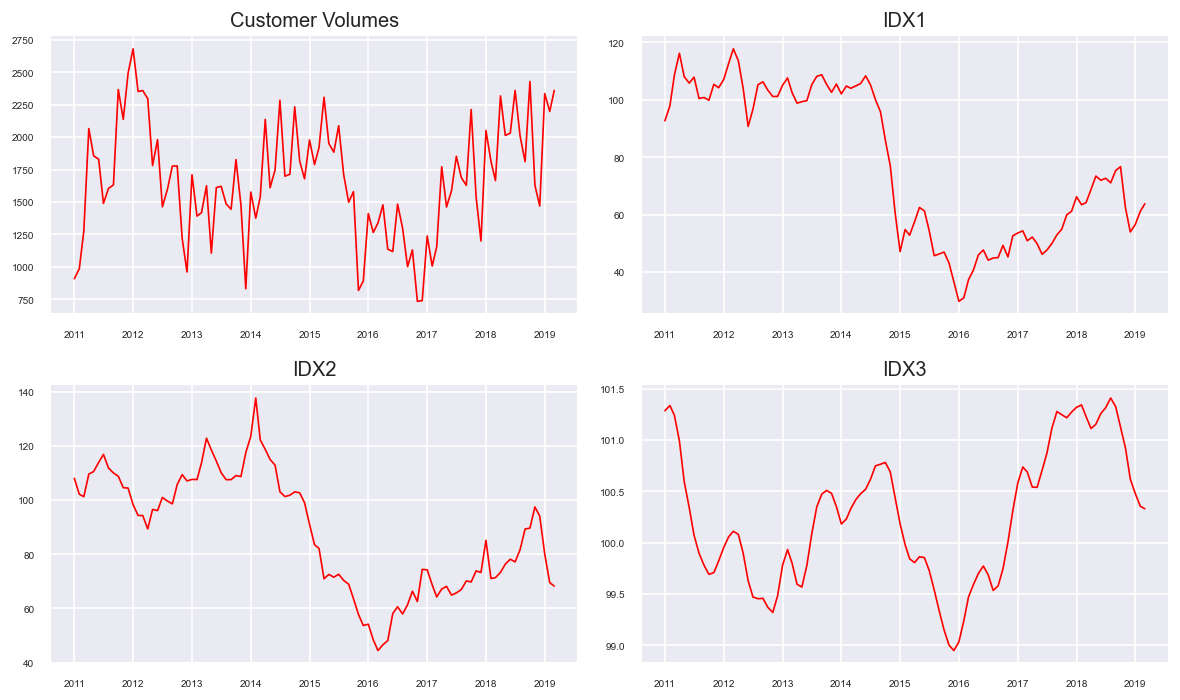

In [5]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)
plt.tight_layout()

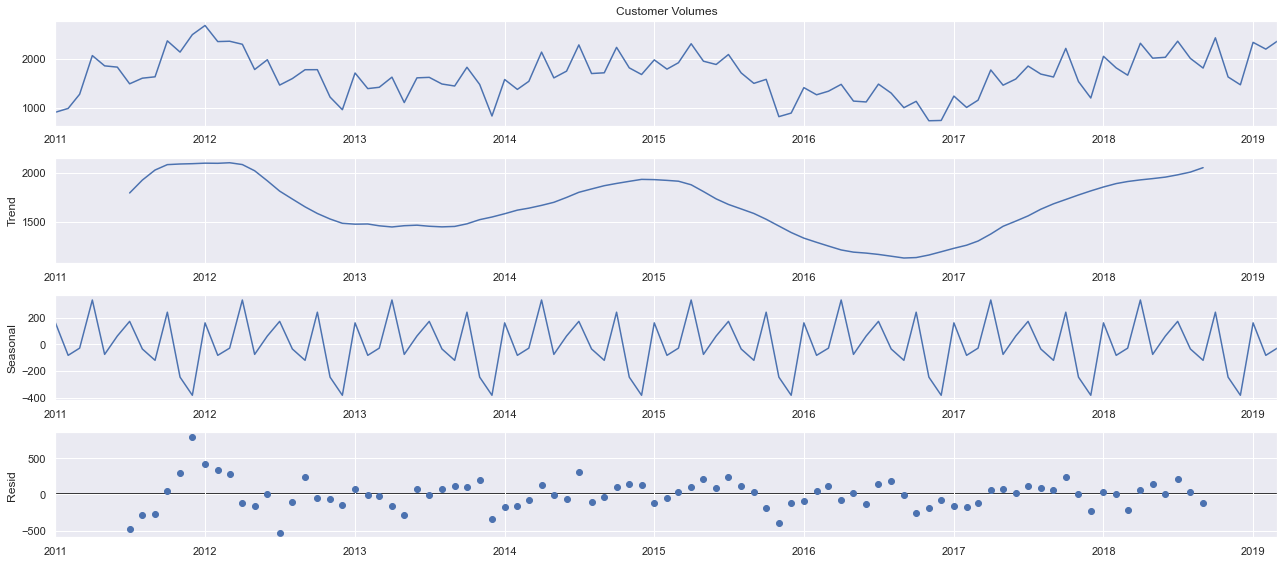

In [6]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(df['Customer Volumes'], model='additive')
fig = decomposition.plot()
plt.show()

In [7]:
def DoLinePlot_wVLines():
    #df = df.loc[df['Date'] >= StartYear].copy()
    data = df[[Series1,Series2]]
    #data = data.set_index('Date').resample('Q').mean()
    sns.set(font_scale=1.5)
    x = data.index
    y = data[Series1]
    y1 = data[Series2]
    fig, ax1 = plt.subplots(figsize = (15,7.5))
    ax2 = ax1.twinx()
    ax1.plot(x, y)
    ax2.plot(x, y1, color="red" )
    ax1.set_xlabel('Dateline')
    ax1.set_ylabel(Series1, color='b')
    ax2.set_ylabel(Series2, color='r')
    fig.autofmt_xdate()
 
    # plot inflection points
    plt.axvline(x = datetime.fromisoformat("2012-01-01"), color='g')
    plt.axvline(x = datetime.fromisoformat("2013-12-01"), color='g')
    plt.axvline(x = datetime.fromisoformat("2015-04-01"), color='g')
    plt.axvline(x = datetime.fromisoformat("2015-11-01"), color='g')
    plt.axvline(x = datetime.fromisoformat("2016-11-01"), color='g')
    plt.axvline(x = datetime.fromisoformat("2018-10-01"), color='g')
    
    plt.show()

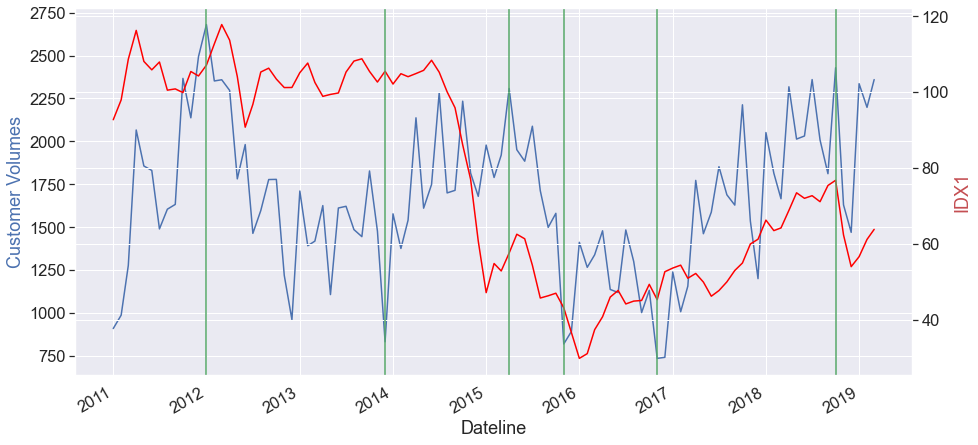

In [8]:
Series1 = "Customer Volumes"
Series2 = "IDX1"
DoLinePlot_wVLines()

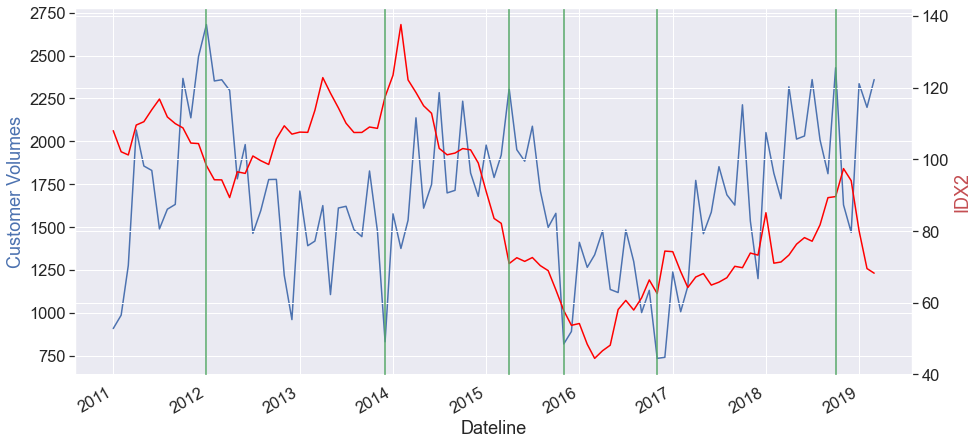

In [9]:
Series1 = "Customer Volumes"
Series2 = "IDX2"
DoLinePlot_wVLines()

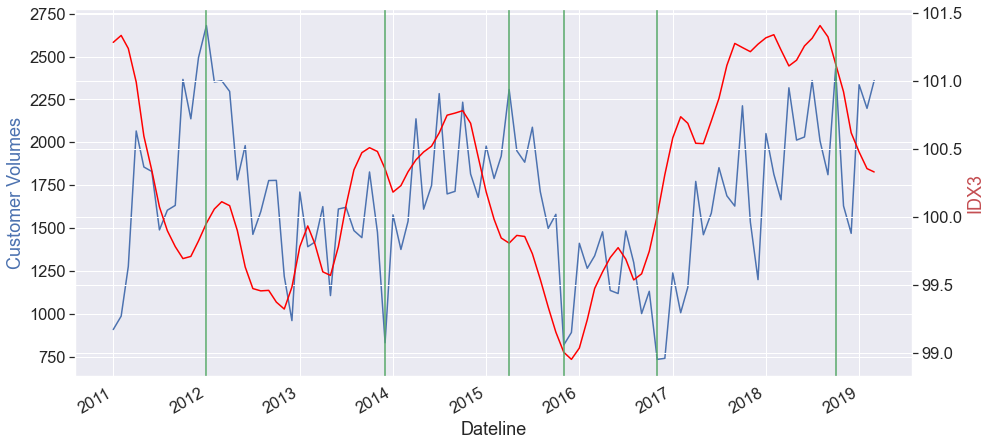

In [10]:
Series1 = "Customer Volumes"
Series2 = "IDX3"
DoLinePlot_wVLines()

### Split into Train and Test

In [11]:
n_obs=18

df_train, df_test = df[0:-n_obs], df[-n_obs:]
print(df_train.shape, df_test.shape)

(81, 4) (18, 4)


### ADF Stationary Test

In [12]:
### 1. ADF statistic less than several critical values
### 2. P-Value less than 0.05

In [13]:
from statsmodels.tsa.stattools import adfuller
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [14]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Customer Volumes" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.1179
 No. Lags Chosen       = 12
 Critical value 1%     = -3.53
 Critical value 5%     = -2.905
 Critical value 10%    = -2.59
 => P-Value = 0.0253. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "IDX1" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.1394
 No. Lags Chosen       = 1
 Critical value 1%     = -3.516
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.6991. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "IDX2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Sta

###  First order difference transform

Clearly, our series are non stationary, so let's go ahead and use the first order difference method and check if they are stationary

In [15]:
df_differenced = df_train.diff().dropna()

In [16]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Customer Volumes" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.9075
 No. Lags Chosen       = 11
 Critical value 1%     = -3.53
 Critical value 5%     = -2.905
 Critical value 10%    = -2.59
 => P-Value = 0.0445. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "IDX1" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.1381
 No. Lags Chosen       = 0
 Critical value 1%     = -3.516
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "IDX2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Le

It looks like the first order difference worked to make our time series stationary. Let's move to seeing which indicators are leading using granger's causality test

### Granger Causality test

We want to identify if any of the indices are leading indicators. A quick visual plot showed that Index 3 has peaks and troughs that clearly lead the peaks and troughs in the customer volume. 

Let's dig in deeper and do an actual statistical test to see which of the indices can be used to predict customer volumes. 

Granger's Causality Test is used to confirm or deny if one time series can be used to predict another time series. Any time series that has a p-value less than the level of significance satisty the properties of causality - the feature must be be leading the target variable, the magnitude of change in the feature corresponds to a proportional level of change in the target, etc. 

In our case we want to see if indices 1, 2 and 3 can be used to predict customer volume.

Granger's causality test requires:

* the input time series to be stationary

In [17]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=13
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df_differenced, variables = df_differenced.columns)  

,Customer Volumes_x,IDX1_x,IDX2_x,IDX3_x
Customer Volumes_y,1.0000,0.0011,0.1937,0.0113
IDX1_y,0.1348,1.0000,0.0334,0.0004
IDX2_y,0.6241,0.0010,1.0000,0.0003
IDX3_y,0.0004,0.0820,0.0001,1.0000


From the results of the grangers causality test, we can clearly see that the idx1 and idx3 can be used as leading indicators to predict customer volumes for a maximum lag of 6 months because their p-values are less than the level of significance = 0.05 . 

### Cointegration Test

To apply VAR model, we want to examine the conintegrated, if there exists a linear combination of them that has an order of integration (d) less than that of the individual series

In [18]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): 
        return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df_differenced)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Customer Volumes ::  73.95     > 40.1749   =>   True
IDX1   ::  35.54     > 24.2761   =>   True
IDX2   ::  19.3      > 12.3212   =>   True
IDX3   ::  5.95      > 4.1296    =>   True


### Select the Order (P) of VAR model

In [19]:
df_differenced = df_differenced[['Customer Volumes','IDX1','IDX3']]

In [20]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  10.386755538932084
BIC :  10.746671668420746
FPE :  32435.71966640182
HQIC:  10.530948952068744 

Lag Order = 2
AIC :  9.800789089846907
BIC :  10.43528762010949
FPE :  18074.21633388916
HQIC:  10.05479050618133 

Lag Order = 3
AIC :  9.65092973835701
BIC :  10.564100681936369
FPE :  15605.13735928204
HQIC:  10.016190093606987 

Lag Order = 4
AIC :  9.64186623744201
BIC :  10.83790045153631
FPE :  15553.724054816012
HQIC:  10.119859361724876 

Lag Order = 5
AIC :  9.774936108989381
BIC :  11.258128501652621
FPE :  17942.048169015667
HQIC:  10.36715854475957 

Lag Order = 6
AIC :  9.589716315032712
BIC :  11.364469157095384
FPE :  15138.170763437536
HQIC:  10.297687043626176 

Lag Order = 7
AIC :  9.696625437706592
BIC :  11.767451781758563
FPE :  17232.631337882744
HQIC:  10.521885501293657 

Lag Order = 8
AIC :  9.705071315167974
BIC :  12.076598522476363
FPE :  17951.484854863953
HQIC:  10.649183319134526 

Lag Order = 9
AIC :  9.703460609646799
BIC :  12.3804339

In [21]:
x = model.select_order(maxlags=13)
x.summary()

,AIC,BIC,FPE,HQIC
0,11.08,11.17,6.457e+04,11.11
1,10.24,10.63,2.792e+04,10.39
2,9.513,10.20*,1.356e+04,9.786*
3,9.446,10.43,1.274e+04*,9.837
4,9.441,10.72,1.279e+04,9.949
5,9.631,11.21,1.567e+04,10.26
6,9.707,11.58,1.724e+04,10.45
7,9.629,11.80,1.639e+04,10.49
8,9.541,12.01,1.560e+04,10.52
9,9.489,12.25,1.556e+04,10.58


### 1. Var Model

### Train the VAR Model of Selected Order(p)

In [22]:
model_fitted = model.fit(13)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 05, Jul, 2021
Time:                     16:24:59
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    13.3264
Nobs:                     67.0000    HQIC:                   10.9402
Log likelihood:          -479.359    FPE:                    20466.9
AIC:                      9.37768    Det(Omega_mle):         5024.87
--------------------------------------------------------------------
Results for equation Customer Volumes
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                      -51.914525        48.829514           -1.063           0.288
L1.Customer Volumes         -0.334685         0.181148           -1.848           0.065
L1.IDX1              

### Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic

In [23]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df_differenced.columns, out):
    print(col, ':', round(val, 2))


Customer Volumes : 1.97
IDX1 : 2.18
IDX3 : 1.87


### Forecast VAR model using statsmodels

In [24]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

13


array([[-2.98000000e+02,  1.66666667e-01,  4.51100000e-02],
       [ 1.30000000e+02,  4.25000000e+00,  1.65820000e-01],
       [-3.97000000e+02, -4.03333333e+00,  2.61770000e-01],
       [ 6.00000000e+00,  7.36000000e+00,  3.03000000e-01],
       [ 4.98000000e+02,  9.70000000e-01,  2.70400000e-01],
       [-2.32000000e+02,  7.63333333e-01,  1.55400000e-01],
       [ 1.49000000e+02, -3.45000000e+00, -4.83000000e-02],
       [ 6.17000000e+02,  1.26000000e+00, -1.46900000e-01],
       [-3.11000000e+02, -2.27000000e+00, -2.60000000e-03],
       [ 1.26000000e+02, -3.72666667e+00,  1.66600000e-01],
       [ 2.65000000e+02,  1.49000000e+00,  1.66400000e-01],
       [-1.64000000e+02,  2.28666667e+00,  2.42900000e-01],
       [-6.00000000e+01,  3.00666667e+00,  1.61800000e-01]])

In [25]:
df_selected = df[['Customer Volumes','IDX1','IDX3']]

In [26]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=n_obs)
df_forecast = pd.DataFrame(fc, index=df_selected.index[-n_obs:], columns=df_selected.columns + '_pred')
df_forecast

,Customer Volumes_pred,IDX1_pred,IDX3_pred
Month,,,
2017-10-01,384.805607,-11.382315,-0.008836
2017-11-01,-437.786837,-10.186532,-0.216428
2017-12-01,-27.597831,-5.219113,-0.292797
2018-01-01,483.310200,-4.218701,-0.258670
2018-02-01,-327.594337,-3.199339,-0.094856
2018-03-01,208.650708,-0.428344,-0.046078
2018-04-01,269.036879,-0.369242,0.017514
2018-05-01,-572.222375,2.555019,0.078183
2018-06-01,129.335641,-4.344196,0.057294


In [27]:
def invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_pred'].cumsum()
    return df_fc

In [28]:
df_results = invert_transformation(df_train[['Customer Volumes','IDX1','IDX3']], df_forecast)

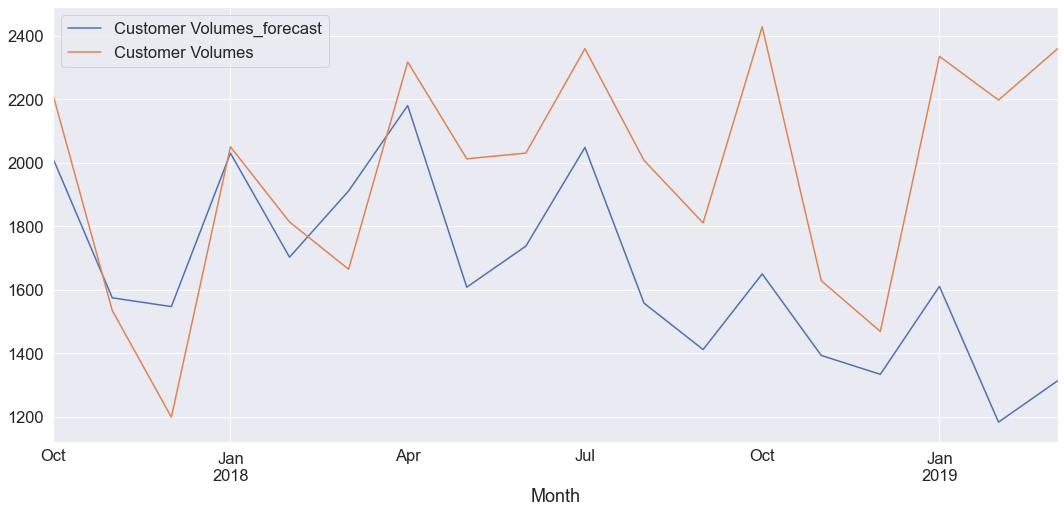

In [29]:
df_results['Customer Volumes'+'_forecast'].plot(legend=True)
df_test['Customer Volumes'][-n_obs:].plot(legend=True)
ax.set_title('Customer Volumes' + ": Forecast vs Actuals")
plt.show()

### Evaluate

In [30]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

def adjust(val, length= 6): 
        return str(val).ljust(length)
print('Forecast Accuracy of: Customer Volumes')
accuracy_prod = forecast_accuracy(df_results['Customer Volumes_forecast'].values, df_test['Customer Volumes'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))


Forecast Accuracy of: Customer Volumes
mape   :  0.1877
me     :  -312.5384
mae    :  383.1192
mpe    :  -0.1361
rmse   :  488.3598
corr   :  0.2968
minmax :  0.183


### next 18 month forecast

In [31]:
df_difference_all = df.diff().dropna()

In [32]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_difference_all.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Customer Volumes" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.8634
 No. Lags Chosen       = 11
 Critical value 1%     = -3.509
 Critical value 5%     = -2.896
 Critical value 10%    = -2.585
 => P-Value = 0.0498. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "IDX1" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.8751
 No. Lags Chosen       = 1
 Critical value 1%     = -3.5
 Critical value 5%     = -2.892
 Critical value 10%    = -2.583
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "IDX2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Le

In [33]:
df_difference_all = df_difference_all[['Customer Volumes','IDX1','IDX3']]

In [34]:
# selected lag order=3 from above
model_fitted = model.fit(13)

In [35]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  

# Input data for forecasting
forecast_input = df_difference_all.values[-lag_order:]
forecast_input

13


array([[-1.49000000e+02,  7.06666667e-01, -1.12100000e-01],
       [ 6.53000000e+02,  4.62666667e+00, -1.17900000e-01],
       [-3.05000000e+02,  4.63666667e+00,  4.23000000e-02],
       [ 1.80000000e+01, -1.45333333e+00,  1.04800000e-01],
       [ 3.29000000e+02,  6.90000000e-01,  5.65000000e-02],
       [-3.52000000e+02, -1.58333333e+00,  9.38000000e-02],
       [-1.97000000e+02,  4.28000000e+00, -8.32000000e-02],
       [ 6.18000000e+02,  1.36333333e+00, -1.98400000e-01],
       [-8.00000000e+02, -1.44100000e+01, -2.06000000e-01],
       [-1.60000000e+02, -8.35666667e+00, -3.02000000e-01],
       [ 8.67000000e+02,  2.62333333e+00, -1.40900000e-01],
       [-1.38000000e+02,  4.55000000e+00, -1.22800000e-01],
       [ 1.62000000e+02,  2.65333333e+00, -2.47000000e-02]])

In [36]:
# Forecast
indexes=indexes.set_index('Month')
fc = model_fitted.forecast(y=forecast_input, steps=18)
df_forecast_18 = pd.DataFrame(fc, index=indexes.index[-18:], columns=df_difference_all.columns + '_pred')
df_forecast_18

,Customer Volumes_pred,IDX1_pred,IDX3_pred
Month,,,
2019-04-01,149.018231,-9.142526,0.217354
2019-05-01,-1045.894260,8.629520,0.245608
2019-06-01,598.336179,-8.870957,0.182720
2019-07-01,56.029884,-4.787258,0.174137
2019-08-01,-112.112430,-3.100225,-0.132450
2019-09-01,7.629764,-12.577083,-0.369512
2019-10-01,-240.821180,0.201288,-0.414249
2019-11-01,-48.084518,0.749971,-0.233831
2019-12-01,-36.455281,-1.954341,0.097653


In [37]:
df_results_18 = invert_transformation(df[['Customer Volumes','IDX1','IDX3']], df_forecast_18)

In [38]:
df_results_18[['Customer Volumes_forecast']]

,Customer Volumes_forecast
Month,
2019-04-01,2509.018231
2019-05-01,1463.123971
2019-06-01,2061.460150
2019-07-01,2117.490033
2019-08-01,2005.377604
2019-09-01,2013.007368
2019-10-01,1772.186188
2019-11-01,1724.101671
2019-12-01,1687.646390


### 2. fbprophet

In [39]:
import itertools
from prophet import Prophet

In [40]:
# prepare data for fbprophet model
df = df.reset_index()
df.columns = ['ds', 'y', 'IDX1', 'IDX2', 'IDX3']

In [41]:
df_fb = df.copy()
df_fb.head()

,ds,y,IDX1,IDX2,IDX3
0,2011-01-01,908.0,92.690595,108.008014,101.2842
1,2011-02-01,986.0,97.914192,102.123691,101.3352
2,2011-03-01,1276.0,108.645217,101.238374,101.2392
3,2011-04-01,2066.0,116.243167,109.568848,100.9917
4,2011-05-01,1856.0,108.068513,110.511852,100.5940


In [42]:
df.head()
df.columns =['ds', 'y', 'IDX1', 'IDX2', 'IDX3']
future_idx1 = indexes['IDX1'].reset_index(drop=True)
future_idx3 =indexes['IDX3'].reset_index(drop=True)

df=df.dropna(how='any')
df=df.reset_index(drop=True)
df.tail()

,ds,y,IDX1,IDX2,IDX3
94,2018-11-01,1629.0,62.316667,97.431685,100.9204
95,2018-12-01,1469.0,53.960000,94.062920,100.6184
96,2019-01-01,2336.0,56.583333,80.055366,100.4775
97,2019-02-01,2198.0,61.133333,69.545042,100.3547
98,2019-03-01,2360.0,63.786667,68.259255,100.3300


### hyperparameter tuning for prophet

In [43]:
# choosing cutoffs to mark the macro inflection points
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
cutoffs = pd.to_datetime(['2013-11-01', '2016-11-01'])


param_grid = {  
    'changepoint_prior_scale': [ .5, .6, .8],
    'seasonality_prior_scale': [1.0, 5.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params, growth='linear',
            seasonality_mode='multiplicative', 
            daily_seasonality=False, 
            weekly_seasonality=False,
            ).add_regressor('IDX1').add_regressor('IDX3').fit(df)
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='90 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc697b88b10>



Initial log joint probability = -125.634
Iteration  1. Log joint probability =    44.2129. Improved by 169.847.
Iteration  2. Log joint probability =    89.2551. Improved by 45.0422.
Iteration  3. Log joint probability =    115.378. Improved by 26.1225.
Iteration  4. Log joint probability =    121.405. Improved by 6.02737.
Iteration  5. Log joint probability =    125.515. Improved by 4.11047.
Iteration  6. Log joint probability =    127.599. Improved by 2.08351.
Iteration  7. Log joint probability =    130.968. Improved by 3.36934.
Iteration  8. Log joint probability =    139.144. Improved by 8.17539.
Iteration  9. Log joint probability =     139.55. Improved by 0.406203.
Iteration 10. Log joint probability =    140.672. Improved by 1.12257.
Iteration 11. Log joint probability =    141.399. Improved by 0.726845.
Iteration 12. Log joint probability =    141.425. Improved by 0.0253647.
Iteration 13. Log joint probability =    141.467. Improved by 0.0425376.
Iteration 14. Log joint proba

Iteration 151. Log joint probability =    187.786. Improved by 0.0133498.
Iteration 152. Log joint probability =    187.792. Improved by 0.00560114.
Iteration 153. Log joint probability =      187.8. Improved by 0.00810658.
Iteration 154. Log joint probability =    187.801. Improved by 0.00138392.
Iteration 155. Log joint probability =    187.805. Improved by 0.00402593.
Iteration 156. Log joint probability =    187.807. Improved by 0.0015413.
Iteration 157. Log joint probability =    187.807. Improved by 0.00038515.
Iteration 158. Log joint probability =    187.807. Improved by 0.000178642.
Iteration 159. Log joint probability =    187.807. Improved by 2.26502e-05.
Iteration 160. Log joint probability =    187.808. Improved by 0.000386095.
Iteration 161. Log joint probability =    188.111. Improved by 0.303585.
Iteration 162. Log joint probability =    188.116. Improved by 0.00411356.
Iteration 163. Log joint probability =    188.118. Improved by 0.00238419.
Iteration 164. Log joint p

Iteration 42. Log joint probability =     89.107. Improved by 0.00689707.
Iteration 27. Log joint probability =    105.986. Improved by 0.180879.
Iteration 43. Log joint probability =     89.165. Improved by 0.058007.
Iteration 28. Log joint probability =    106.001. Improved by 0.015178.
Iteration 44. Log joint probability =    89.6354. Improved by 0.470414.
Iteration 45. Log joint probability =     89.653. Improved by 0.0175971.
Iteration 29. Log joint probability =    106.022. Improved by 0.0211297.
Iteration 46. Log joint probability =    89.7859. Improved by 0.132889.
Iteration 30. Log joint probability =    106.031. Improved by 0.00873729.
Iteration 47. Log joint probability =     89.787. Improved by 0.00111034.
Iteration 48. Log joint probability =    89.7948. Improved by 0.00779829.
Iteration 31. Log joint probability =    106.031. Improved by 0.000168566.
Iteration 49. Log joint probability =    89.7981. Improved by 0.00326489.
Iteration 32. Log joint probability =    106.039.

Iteration 82. Log joint probability =    137.539. Improved by 0.00784603.
Iteration 83. Log joint probability =    137.543. Improved by 0.00339015.
Iteration 84. Log joint probability =    137.581. Improved by 0.0388042.
Iteration 85. Log joint probability =    137.678. Improved by 0.096293.
Iteration 86. Log joint probability =    137.922. Improved by 0.243958.
Iteration 87. Log joint probability =    138.019. Improved by 0.0969113.
Iteration 88. Log joint probability =    138.536. Improved by 0.517754.
Iteration 89. Log joint probability =    138.714. Improved by 0.177929.
Iteration 90. Log joint probability =    139.205. Improved by 0.490402.
Iteration 91. Log joint probability =    139.355. Improved by 0.150178.
Iteration 92. Log joint probability =    139.868. Improved by 0.51315.
Iteration 93. Log joint probability =      140.2. Improved by 0.332286.
Iteration 94. Log joint probability =    140.217. Improved by 0.0169386.
Iteration 95. Log joint probability =    140.546. Improved

Iteration 201. Log joint probability =    144.192. Improved by 0.000214188.
Iteration 202. Log joint probability =    144.193. Improved by 0.000145028.
Iteration 203. Log joint probability =    144.193. Improved by 0.000178995.
Iteration 204. Log joint probability =    144.193. Improved by 0.000195417.
Iteration 205. Log joint probability =    144.193. Improved by 0.000104162.
Iteration 206. Log joint probability =    144.193. Improved by 9.44421e-06.
Iteration 207. Log joint probability =    144.193. Improved by 0.000176504.
Iteration 208. Log joint probability =    144.193. Improved by 5.38402e-06.
Iteration 209. Log joint probability =    144.193. Improved by 2.01414e-05.
Iteration 210. Log joint probability =    144.193. Improved by 3.51802e-05.
Iteration 211. Log joint probability =    144.193. Improved by 2.94396e-05.
Iteration 212. Log joint probability =    144.193. Improved by 3.77117e-06.
Iteration 213. Log joint probability =    144.193. Improved by 1.46515e-05.
Iteration 21

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc696d6c310>



Initial log joint probability = -157.823
Iteration  1. Log joint probability =    42.2492. Improved by 200.072.
Iteration  2. Log joint probability =    99.6308. Improved by 57.3816.
Iteration  3. Log joint probability =    102.226. Improved by 2.59507.
Iteration  4. Log joint probability =    123.472. Improved by 21.2461.
Iteration  5. Log joint probability =     123.48. Improved by 0.00783512.
Iteration  6. Log joint probability =    123.491. Improved by 0.0112842.
Iteration  7. Log joint probability =    123.532. Improved by 0.0404076.
Iteration  8. Log joint probability =    123.578. Improved by 0.0466773.
Iteration  9. Log joint probability =    123.624. Improved by 0.0455535.
Iteration 10. Log joint probability =    136.257. Improved by 12.6332.
Iteration 11. Log joint probability =     136.47. Improved by 0.213351.
Iteration 12. Log joint probability =    136.579. Improved by 0.108286.
Iteration 13. Log joint probability =    136.794. Improved by 0.214866.
Iteration 14. Log joi

Iteration 177. Log joint probability =    189.211. Improved by 3.18561e-07.
Iteration 178. Log joint probability =    189.211. Improved by 2.19629e-07.
Iteration 179. Log joint probability =    189.211. Improved by 4.13906e-07.
Iteration 180. Log joint probability =    189.211. Improved by 1.49599e-07.
Iteration 181. Log joint probability =    189.211. Improved by 1.73004e-07.
Iteration 182. Log joint probability =    189.211. Improved by 7.3702e-08.
Iteration 183. Log joint probability =    189.211. Improved by 6.13798e-08.
Iteration 184. Log joint probability =    189.211. Improved by 5.44748e-09.

Initial log joint probability = -97.6918
Iteration  1. Log joint probability =    3.68631. Improved by 101.378.

Initial log joint probability = -133.638
Iteration  2. Log joint probability =    17.9436. Improved by 14.2573.
Iteration  1. Log joint probability =  0.0627741. Improved by 133.7.
Iteration  3. Log joint probability =    17.9473. Improved by 0.00375833.
Iteration  4. Log joint 

Iteration 83. Log joint probability =    45.8165. Improved by 0.771755.
Iteration 54. Log joint probability =    119.842. Improved by 0.0439881.
Iteration 84. Log joint probability =    46.1675. Improved by 0.35097.
Iteration 55. Log joint probability =    119.922. Improved by 0.0805917.
Iteration 85. Log joint probability =    46.3557. Improved by 0.188247.
Iteration 56. Log joint probability =    119.953. Improved by 0.0307185.
Iteration 86. Log joint probability =    46.4339. Improved by 0.0781447.
Iteration 87. Log joint probability =    46.4543. Improved by 0.0203734.
Iteration 57. Log joint probability =    120.068. Improved by 0.115326.
Iteration 88. Log joint probability =    46.5061. Improved by 0.0518794.
Iteration 58. Log joint probability =     120.09. Improved by 0.0216788.
Iteration 89. Log joint probability =    46.5528. Improved by 0.0467121.
Iteration 90. Log joint probability =    46.5782. Improved by 0.02535.
Iteration 59. Log joint probability =    120.096. Improved

Iteration 168. Log joint probability =      88.72. Improved by 0.00368826.
Iteration 112. Log joint probability =    144.569. Improved by 0.0510932.
Iteration 169. Log joint probability =    89.7104. Improved by 0.990394.
Iteration 170. Log joint probability =    89.7719. Improved by 0.0615147.
Iteration 113. Log joint probability =    144.591. Improved by 0.0217073.
Iteration 171. Log joint probability =    90.4094. Improved by 0.637507.
Iteration 114. Log joint probability =    144.597. Improved by 0.0060547.
Iteration 172. Log joint probability =    90.7163. Improved by 0.306904.
Iteration 173. Log joint probability =    90.9516. Improved by 0.235273.
Iteration 115. Log joint probability =    144.612. Improved by 0.0153457.
Iteration 174. Log joint probability =    90.9602. Improved by 0.00866606.
Iteration 116. Log joint probability =    144.614. Improved by 0.00141025.
Iteration 175. Log joint probability =    91.0645. Improved by 0.104267.
Iteration 176. Log joint probability =  

Iteration 158. Log joint probability =     145.49. Improved by 3.69711e-05.
Iteration 237. Log joint probability =    94.8128. Improved by 0.668167.
Iteration 238. Log joint probability =    94.8303. Improved by 0.017553.
Iteration 159. Log joint probability =     145.49. Improved by 8.69405e-05.
Iteration 239. Log joint probability =    94.8347. Improved by 0.00440792.
Iteration 160. Log joint probability =     145.49. Improved by 1.03734e-06.
Iteration 240. Log joint probability =    95.0036. Improved by 0.168882.
Iteration 241. Log joint probability =    95.0048. Improved by 0.00119195.
Iteration 161. Log joint probability =     145.49. Improved by 0.000100325.
Iteration 242. Log joint probability =    95.0064. Improved by 0.00158375.
Iteration 162. Log joint probability =     145.49. Improved by 6.38138e-05.
Iteration 243. Log joint probability =    95.0093. Improved by 0.00286669.
Iteration 244. Log joint probability =    95.0134. Improved by 0.00415914.
Iteration 163. Log joint p

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc697e7dc90>



Initial log joint probability = -171.685
Iteration  1. Log joint probability =    41.5225. Improved by 213.208.
Iteration  2. Log joint probability =    98.3019. Improved by 56.7795.
Iteration  3. Log joint probability =     122.72. Improved by 24.4185.
Iteration  4. Log joint probability =    147.031. Improved by 24.3106.
Iteration  5. Log joint probability =    147.045. Improved by 0.0143526.
Iteration  6. Log joint probability =    147.066. Improved by 0.0201555.
Iteration  7. Log joint probability =     147.08. Improved by 0.0140919.
Iteration  8. Log joint probability =    147.098. Improved by 0.0185372.
Iteration  9. Log joint probability =    147.105. Improved by 0.00726893.
Iteration 10. Log joint probability =     147.14. Improved by 0.0349361.
Iteration 11. Log joint probability =    147.339. Improved by 0.198584.
Iteration 12. Log joint probability =    148.419. Improved by 1.07985.
Iteration 13. Log joint probability =    148.598. Improved by 0.178689.
Iteration 14. Log jo

Iteration 192. Log joint probability =    187.191. Improved by 0.00067897.
Iteration 193. Log joint probability =    187.198. Improved by 0.00610365.
Iteration 194. Log joint probability =    187.206. Improved by 0.00833768.
Iteration 195. Log joint probability =    187.294. Improved by 0.088154.
Iteration 196. Log joint probability =    187.301. Improved by 0.00720253.
Iteration 197. Log joint probability =    187.317. Improved by 0.0158855.
Iteration 198. Log joint probability =    187.321. Improved by 0.0043647.
Iteration 199. Log joint probability =    187.329. Improved by 0.00702559.
Iteration 200. Log joint probability =    187.437. Improved by 0.108153.
Iteration 201. Log joint probability =    187.548. Improved by 0.111256.
Iteration 202. Log joint probability =    187.686. Improved by 0.13798.
Iteration 203. Log joint probability =    187.758. Improved by 0.0725839.
Iteration 204. Log joint probability =    188.503. Improved by 0.744702.
Iteration 205. Log joint probability = 

Iteration 20. Log joint probability =    44.1534. Improved by 0.357553.
Iteration 13. Log joint probability =    86.7037. Improved by 0.0319013.
Iteration 21. Log joint probability =    44.3134. Improved by 0.159988.
Iteration 22. Log joint probability =    44.4489. Improved by 0.135561.
Iteration 14. Log joint probability =    86.7511. Improved by 0.0473986.
Iteration 23. Log joint probability =    44.4614. Improved by 0.0125196.
Iteration 15. Log joint probability =    87.1859. Improved by 0.434743.
Iteration 24. Log joint probability =    44.4732. Improved by 0.0117926.
Iteration 25. Log joint probability =    44.5065. Improved by 0.0332901.
Iteration 16. Log joint probability =    87.6731. Improved by 0.487248.
Iteration 26. Log joint probability =    44.5239. Improved by 0.0173638.
Iteration 17. Log joint probability =     87.908. Improved by 0.234894.
Iteration 27. Log joint probability =    44.5283. Improved by 0.0044296.
Iteration 28. Log joint probability =    44.5389. Improve

Iteration 67. Log joint probability =    94.7734. Improved by 0.056023.
Iteration 103. Log joint probability =    61.5368. Improved by 0.0172482.
Iteration 68. Log joint probability =    94.8057. Improved by 0.0322887.
Iteration 104. Log joint probability =    61.5501. Improved by 0.013325.
Iteration 105. Log joint probability =    61.6124. Improved by 0.0622548.
Iteration 69. Log joint probability =    94.8628. Improved by 0.0570788.
Iteration 106. Log joint probability =    62.3469. Improved by 0.734572.
Iteration 70. Log joint probability =    94.8796. Improved by 0.0168461.
Iteration 107. Log joint probability =    65.9722. Improved by 3.62531.
Iteration 108. Log joint probability =    68.3729. Improved by 2.40069.
Iteration 71. Log joint probability =     94.896. Improved by 0.016335.
Iteration 109. Log joint probability =    69.3118. Improved by 0.938899.
Iteration 72. Log joint probability =    94.9676. Improved by 0.0715837.
Iteration 110. Log joint probability =    69.4244. Im

Iteration 123. Log joint probability =    141.252. Improved by 0.0408685.
Iteration 188. Log joint probability =    92.7616. Improved by 0.0116059.
Iteration 124. Log joint probability =    141.378. Improved by 0.125551.
Iteration 189. Log joint probability =    92.8207. Improved by 0.0591221.
Iteration 190. Log joint probability =    92.8682. Improved by 0.0475446.
Iteration 125. Log joint probability =    141.409. Improved by 0.0312887.
Iteration 191. Log joint probability =    92.9734. Improved by 0.105151.
Iteration 126. Log joint probability =    141.421. Improved by 0.0122226.
Iteration 192. Log joint probability =     93.112. Improved by 0.138583.
Iteration 193. Log joint probability =    93.1898. Improved by 0.0778752.
Iteration 127. Log joint probability =    141.422. Improved by 0.00113208.
Iteration 194. Log joint probability =    93.2298. Improved by 0.0399573.
Iteration 128. Log joint probability =    141.434. Improved by 0.0115689.
Iteration 195. Log joint probability =  

Iteration 166. Log joint probability =    143.999. Improved by 0.0158159.
Iteration 256. Log joint probability =    95.2655. Improved by 0.000170867.
Iteration 257. Log joint probability =    95.2655. Improved by 1.09611e-05.
Iteration 167. Log joint probability =    143.999. Improved by 0.000874196.
Iteration 258. Log joint probability =    95.2656. Improved by 6.39464e-05.
Iteration 168. Log joint probability =     144.07. Improved by 0.0703909.
Iteration 259. Log joint probability =    95.2658. Improved by 0.000222096.
Iteration 260. Log joint probability =    95.2659. Improved by 8.88835e-05.
Iteration 169. Log joint probability =    144.073. Improved by 0.00338742.
Iteration 261. Log joint probability =     95.266. Improved by 0.000113424.
Iteration 170. Log joint probability =    144.207. Improved by 0.13376.
Iteration 262. Log joint probability =     95.266. Improved by 5.9787e-05.
Iteration 263. Log joint probability =    95.2661. Improved by 4.67248e-05.
Iteration 171. Log joi

Iteration 241. Log joint probability =    145.521. Improved by 5.99903e-07.
Iteration 242. Log joint probability =    145.521. Improved by 1.13974e-06.
Iteration 243. Log joint probability =    145.521. Improved by 9.76328e-07.
Iteration 244. Log joint probability =    145.521. Improved by 1.73828e-06.
Iteration 245. Log joint probability =    145.521. Improved by 1.49796e-06.
Iteration 246. Log joint probability =    145.521. Improved by 8.40085e-08.
Iteration 247. Log joint probability =    145.521. Improved by 5.98355e-08.
Iteration 248. Log joint probability =    145.521. Improved by 1.65456e-06.
Iteration 249. Log joint probability =    145.521. Improved by 6.17212e-07.
Iteration 250. Log joint probability =    145.521. Improved by 7.6038e-07.
Iteration 251. Log joint probability =    145.521. Improved by 4.49909e-07.
Iteration 252. Log joint probability =    145.521. Improved by 1.50086e-07.
Iteration 253. Log joint probability =    145.521. Improved by 2.05084e-07.
Iteration 254

Iteration 151. Log joint probability =    180.609. Improved by 0.0215678.1. Improved by 0.00067897.
Iteration 193. Log joint probability =    187.198. Improved by 0.00610365.
Iteration 194. Log joint probability =    187.206. Improved by 0.00833768.
Iteration 195. Log joint probability =    187.294. Improved by 0.088154.
Iteration 196. Log joint probability =    187.301. Improved by 0.00720253.
Iteration 197. Log joint probability =    187.317. Improved by 0.0158855.
Iteration 198. Log joint probability =    187.321. Improved by 0.0043647.
Iteration 199. Log joint probability =    187.329. Improved by 0.00702559.
Iteration 200. Log joint probability =    187.437. Improved by 0.108153.
Iteration 201. Log joint probability =    187.548. Improved by 0.111256.
Iteration 202. Log joint probability =    187.686. Improved by 0.13798.
Iteration 203. Log joint probability =    187.758. Improved by 0.0725839.
Iteration 204. Log joint probability =    188.503. Improved by 0.744702.
Iteration 205.

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc697e33b50>



Initial log joint probability = -130.192
Iteration  1. Log joint probability =      44.17. Improved by 174.362.
Iteration  2. Log joint probability =     89.079. Improved by 44.909.
Iteration  3. Log joint probability =    113.531. Improved by 24.4519.
Iteration  4. Log joint probability =    118.224. Improved by 4.69332.
Iteration  5. Log joint probability =    120.323. Improved by 2.09902.
Iteration  6. Log joint probability =    122.306. Improved by 1.98288.
Iteration  7. Log joint probability =    122.695. Improved by 0.388602.
Iteration  8. Log joint probability =    124.971. Improved by 2.27648.
Iteration  9. Log joint probability =     125.06. Improved by 0.0886106.
Iteration 10. Log joint probability =    129.258. Improved by 4.19785.
Iteration 11. Log joint probability =     131.51. Improved by 2.2526.
Iteration 12. Log joint probability =    133.396. Improved by 1.88572.
Iteration 13. Log joint probability =    133.594. Improved by 0.197435.
Iteration 14. Log joint probabili

Iteration 125. Log joint probability =     192.51. Improved by 0.00776399.
Iteration 126. Log joint probability =    192.518. Improved by 0.00758674.
Iteration 127. Log joint probability =    192.533. Improved by 0.0153652.
Iteration 128. Log joint probability =    192.546. Improved by 0.0127787.
Iteration 129. Log joint probability =    192.551. Improved by 0.00513649.
Iteration 130. Log joint probability =    192.563. Improved by 0.0118558.
Iteration 131. Log joint probability =    192.564. Improved by 0.00140794.
Iteration 132. Log joint probability =    192.583. Improved by 0.0185883.
Iteration 133. Log joint probability =    192.586. Improved by 0.00341543.
Iteration 134. Log joint probability =    192.836. Improved by 0.25005.
Iteration 135. Log joint probability =     192.89. Improved by 0.0539074.
Iteration 136. Log joint probability =    193.144. Improved by 0.254437.
Iteration 137. Log joint probability =    193.221. Improved by 0.0770007.
Iteration 138. Log joint probability

Iteration 21. Log joint probability =    73.0684. Improved by 0.0522515.
Iteration 13. Log joint probability =    101.996. Improved by 0.0261512.
Iteration 22. Log joint probability =    73.3463. Improved by 0.277884.
Iteration 14. Log joint probability =    102.058. Improved by 0.0611404.
Iteration 23. Log joint probability =    73.3759. Improved by 0.0296217.
Iteration 24. Log joint probability =    73.4427. Improved by 0.066762.
Iteration 15. Log joint probability =    102.108. Improved by 0.0503907.
Iteration 25. Log joint probability =    73.4649. Improved by 0.0221617.
Iteration 16. Log joint probability =    102.138. Improved by 0.0302693.
Iteration 26. Log joint probability =    73.5394. Improved by 0.0745533.
Iteration 27. Log joint probability =     73.554. Improved by 0.014562.
Iteration 17. Log joint probability =    102.146. Improved by 0.00761967.
Iteration 28. Log joint probability =    73.6365. Improved by 0.0825043.
Iteration 18. Log joint probability =    102.151. Imp

Iteration 69. Log joint probability =    109.804. Improved by 0.940948.
Iteration 108. Log joint probability =    89.0801. Improved by 0.0142.
Iteration 109. Log joint probability =     89.098. Improved by 0.017976.
Iteration 70. Log joint probability =    111.402. Improved by 1.59818.
Iteration 110. Log joint probability =    89.0981. Improved by 0.000106591.
Iteration 111. Log joint probability =    89.1106. Improved by 0.0124676.
Iteration 71. Log joint probability =    112.011. Improved by 0.609141.
Iteration 112. Log joint probability =    89.1346. Improved by 0.0239941.
Iteration 72. Log joint probability =    113.225. Improved by 1.21409.
Iteration 113. Log joint probability =    89.1554. Improved by 0.0208243.
Iteration 114. Log joint probability =    89.1686. Improved by 0.0131609.
Iteration 73. Log joint probability =    113.315. Improved by 0.0901782.
Iteration 115. Log joint probability =    89.1745. Improved by 0.00596403.
Iteration 74. Log joint probability =    113.418. 

Iteration 113. Log joint probability =    144.149. Improved by 0.0115091.
Iteration 177. Log joint probability =    94.6253. Improved by 7.02778e-05.
Iteration 114. Log joint probability =    144.158. Improved by 0.00890155.
Iteration 178. Log joint probability =    94.6255. Improved by 0.000183704.
Iteration 179. Log joint probability =    94.6255. Improved by 9.7867e-06.
Iteration 115. Log joint probability =    144.183. Improved by 0.0255945.
Iteration 180. Log joint probability =    94.6258. Improved by 0.000271959.
Iteration 181. Log joint probability =     94.626. Improved by 0.000158213.
Iteration 116. Log joint probability =    144.188. Improved by 0.00506178.
Iteration 182. Log joint probability =    94.6261. Improved by 0.000101998.
Iteration 117. Log joint probability =    144.197. Improved by 0.00875463.
Iteration 183. Log joint probability =    94.6261. Improved by 7.86463e-05.
Iteration 184. Log joint probability =    94.6262. Improved by 4.96361e-05.
Iteration 118. Log j

Iteration 186. Log joint probability =    147.973. Improved by 8.35416e-06.
Iteration 187. Log joint probability =    147.973. Improved by 1.45893e-05.
Iteration 188. Log joint probability =    147.973. Improved by 2.93821e-06.
Iteration 189. Log joint probability =    147.973. Improved by 1.93627e-06.
Iteration 190. Log joint probability =    147.973. Improved by 1.18192e-06.
Iteration 191. Log joint probability =    147.973. Improved by 7.64057e-07.
Iteration 192. Log joint probability =    147.973. Improved by 2.52444e-06.
Iteration 193. Log joint probability =    147.973. Improved by 2.32916e-07.
Iteration 194. Log joint probability =    147.973. Improved by 1.44582e-06.
Iteration 195. Log joint probability =    147.973. Improved by 1.19036e-06.
Iteration 196. Log joint probability =    147.973. Improved by 2.85602e-07.
Iteration 197. Log joint probability =    147.973. Improved by 1.18298e-07.
Iteration 198. Log joint probability =    147.973. Improved by 1.18928e-06.
Iteration 19

Iteration 111. Log joint probability =    192.3on 125. Log joint probability =     192.51. Improved by 0.00776399.
Iteration 126. Log joint probability =    192.518. Improved by 0.00758674.
Iteration 127. Log joint probability =    192.533. Improved by 0.0153652.
Iteration 128. Log joint probability =    192.546. Improved by 0.0127787.
Iteration 129. Log joint probability =    192.551. Improved by 0.00513649.
Iteration 130. Log joint probability =    192.563. Improved by 0.0118558.
Iteration 131. Log joint probability =    192.564. Improved by 0.00140794.
Iteration 132. Log joint probability =    192.583. Improved by 0.0185883.
Iteration 133. Log joint probability =    192.586. Improved by 0.00341543.
Iteration 134. Log joint probability =    192.836. Improved by 0.25005.
Iteration 135. Log joint probability =     192.89. Improved by 0.0539074.
Iteration 136. Log joint probability =    193.144. Improved by 0.254437.
Iteration 137. Log joint probability =    193.221. Improved by 0.07700

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc697b74d10>



Initial log joint probability = -162.381
Iteration  1. Log joint probability =    42.2565. Improved by 204.637.
Iteration  2. Log joint probability =     103.51. Improved by 61.254.
Iteration  3. Log joint probability =    125.903. Improved by 22.3927.
Iteration  4. Log joint probability =    129.443. Improved by 3.54016.
Iteration  5. Log joint probability =    129.448. Improved by 0.00433369.
Iteration  6. Log joint probability =     129.46. Improved by 0.012492.
Iteration  7. Log joint probability =    129.464. Improved by 0.00394426.
Iteration  8. Log joint probability =    129.477. Improved by 0.012901.
Iteration  9. Log joint probability =    129.484. Improved by 0.00687862.
Iteration 10. Log joint probability =    129.496. Improved by 0.0126097.
Iteration 11. Log joint probability =    129.504. Improved by 0.00796615.
Iteration 12. Log joint probability =    129.514. Improved by 0.00957535.
Iteration 13. Log joint probability =    129.549. Improved by 0.034697.
Iteration 14. Lo

Iteration 138. Log joint probability =    183.402. Improved by 0.293475.
Iteration 139. Log joint probability =    183.857. Improved by 0.455248.
Iteration 140. Log joint probability =    184.425. Improved by 0.567893.
Iteration 141. Log joint probability =    185.365. Improved by 0.94024.
Iteration 142. Log joint probability =    185.566. Improved by 0.201267.
Iteration 143. Log joint probability =    185.856. Improved by 0.289973.
Iteration 144. Log joint probability =    186.007. Improved by 0.150665.
Iteration 145. Log joint probability =    186.347. Improved by 0.340059.
Iteration 146. Log joint probability =    186.365. Improved by 0.0181253.
Iteration 147. Log joint probability =    186.431. Improved by 0.0656142.
Iteration 148. Log joint probability =    186.592. Improved by 0.161466.
Iteration 149. Log joint probability =    186.643. Improved by 0.0509495.
Iteration 150. Log joint probability =    187.075. Improved by 0.432058.
Iteration 151. Log joint probability =    187.287


Initial log joint probability = -102.25

Initial log joint probability = -138.196
Iteration  1. Log joint probability =    3.68313. Improved by 105.933.
Iteration  2. Log joint probability =    17.8729. Improved by 14.1898.
Iteration  1. Log joint probability =  0.0874112. Improved by 138.283.
Iteration  3. Log joint probability =     17.874. Improved by 0.00104875.
Iteration  2. Log joint probability =    69.5948. Improved by 69.5074.
Iteration  4. Log joint probability =    17.8823. Improved by 0.00835219.
Iteration  3. Log joint probability =    84.8365. Improved by 15.2417.
Iteration  5. Log joint probability =    21.5946. Improved by 3.71228.
Iteration  6. Log joint probability =    21.6718. Improved by 0.0771637.
Iteration  4. Log joint probability =     84.842. Improved by 0.00545331.
Iteration  7. Log joint probability =    21.6798. Improved by 0.00804948.
Iteration  8. Log joint probability =    21.7204. Improved by 0.0405573.
Iteration  5. Log joint probability =    84.8615.

Iteration 73. Log joint probability =    43.4424. Improved by 0.482602.
Iteration 74. Log joint probability =    43.9311. Improved by 0.488739.
Iteration 48. Log joint probability =    131.608. Improved by 0.00801008.
Iteration 75. Log joint probability =    43.9799. Improved by 0.0488011.
Iteration 49. Log joint probability =    131.621. Improved by 0.0131919.
Iteration 76. Log joint probability =    44.0032. Improved by 0.0232803.
Iteration 77. Log joint probability =    45.7027. Improved by 1.69949.
Iteration 50. Log joint probability =    131.631. Improved by 0.0101324.
Iteration 78. Log joint probability =    46.1685. Improved by 0.46583.
Iteration 51. Log joint probability =    131.642. Improved by 0.011199.
Iteration 79. Log joint probability =     46.194. Improved by 0.0255343.
Iteration 80. Log joint probability =    46.2022. Improved by 0.00812586.
Iteration 52. Log joint probability =    131.654. Improved by 0.0117843.
Iteration 81. Log joint probability =    46.3216. Improv

Iteration 148. Log joint probability =    91.5896. Improved by 0.0153338.
Iteration 98. Log joint probability =    141.227. Improved by 0.12163.
Iteration 149. Log joint probability =    91.5946. Improved by 0.00501728.
Iteration 150. Log joint probability =    91.6119. Improved by 0.01724.
Iteration 99. Log joint probability =    141.283. Improved by 0.0561325.
Iteration 151. Log joint probability =    91.6225. Improved by 0.0106831.
Iteration 100. Log joint probability =    141.336. Improved by 0.0525552.
Iteration 152. Log joint probability =    92.4738. Improved by 0.85124.
Iteration 153. Log joint probability =    92.5953. Improved by 0.121556.
Iteration 101. Log joint probability =    141.369. Improved by 0.0329727.
Iteration 154. Log joint probability =    92.6259. Improved by 0.0305379.
Iteration 102. Log joint probability =     141.39. Improved by 0.0209966.
Iteration 155. Log joint probability =    92.6448. Improved by 0.0189699.
Iteration 156. Log joint probability =     92.

Iteration 236. Log joint probability =    96.9068. Improved by 2.70618e-05.
Iteration 237. Log joint probability =    96.9068. Improved by 6.11142e-06.
Iteration 155. Log joint probability =    148.852. Improved by 0.00251472.
Iteration 238. Log joint probability =    96.9069. Improved by 5.16694e-06.
Iteration 156. Log joint probability =    148.857. Improved by 0.00513057.
Iteration 239. Log joint probability =    96.9069. Improved by 1.77563e-07.
Iteration 240. Log joint probability =    96.9069. Improved by 1.49304e-05.
Iteration 157. Log joint probability =    148.863. Improved by 0.00614457.
Iteration 241. Log joint probability =    96.9069. Improved by 2.24943e-06.
Iteration 242. Log joint probability =    96.9069. Improved by 3.45311e-06.
Iteration 158. Log joint probability =    148.869. Improved by 0.00558842.
Iteration 243. Log joint probability =    96.9069. Improved by 2.09412e-06.
Iteration 159. Log joint probability =    148.967. Improved by 0.0985854.
Iteration 244. Log

Iteration 233. Log joint probability =    193.n 247. Log joint probability =    194.518. Improved by 0.0138674.
Iteration 248. Log joint probability =    194.538. Improved by 0.0197259.
Iteration 249. Log joint probability =    194.546. Improved by 0.00815753.
Iteration 250. Log joint probability =      194.8. Improved by 0.253493.
Iteration 251. Log joint probability =    194.872. Improved by 0.0725317.
Iteration 252. Log joint probability =    194.873. Improved by 0.000333486.
Iteration 253. Log joint probability =    194.873. Improved by 0.00090128.
Iteration 254. Log joint probability =    194.889. Improved by 0.0150953.
Iteration 255. Log joint probability =    194.892. Improved by 0.00301687.
Iteration 256. Log joint probability =    194.892. Improved by 0.000731939.
Iteration 257. Log joint probability =    194.893. Improved by 0.00037902.
Iteration 258. Log joint probability =    194.893. Improved by 0.000106408.
Iteration 259. Log joint probability =    194.893. Improved by 9.

Iteration 84. Log joint probability =    175.603. Improved by 0.0936679.
Iteration 85. Log joint probability =     176.66. Improved by 1.05642.
Iteration 86. Log joint probability =    177.465. Improved by 0.805503.
Iteration 87. Log joint probability =    177.968. Improved by 0.503189.
Iteration 88. Log joint probability =    178.077. Improved by 0.109168.
Iteration 89. Log joint probability =    178.095. Improved by 0.0174557.
Iteration 90. Log joint probability =    178.431. Improved by 0.336472.
Iteration 91. Log joint probability =    178.447. Improved by 0.0160717.
Iteration 92. Log joint probability =    178.489. Improved by 0.0417252.
Iteration 93. Log joint probability =    178.569. Improved by 0.0797639.
Iteration 94. Log joint probability =    178.665. Improved by 0.0963187.
Iteration 95. Log joint probability =    178.669. Improved by 0.00384017.
Iteration 96. Log joint probability =    178.733. Improved by 0.0638715.
Iteration 97. Log joint probability =     178.79. Improv

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc697e8ca90>



Initial log joint probability = -176.244
Iteration  1. Log joint probability =    41.5319. Improved by 217.775.
Iteration  2. Log joint probability =    97.2772. Improved by 55.7453.
Iteration  3. Log joint probability =    121.169. Improved by 23.8918.
Iteration  4. Log joint probability =    146.519. Improved by 25.3496.
Iteration  5. Log joint probability =    146.527. Improved by 0.00851142.
Iteration  6. Log joint probability =    146.555. Improved by 0.0275415.
Iteration  7. Log joint probability =    146.582. Improved by 0.0268849.
Iteration  8. Log joint probability =    146.881. Improved by 0.299517.
Iteration  9. Log joint probability =    146.888. Improved by 0.00675659.
Iteration 10. Log joint probability =     146.98. Improved by 0.0924405.
Iteration 11. Log joint probability =    147.063. Improved by 0.0831908.
Iteration 12. Log joint probability =    147.579. Improved by 0.515142.
Iteration 13. Log joint probability =     148.12. Improved by 0.541035.
Iteration 14. Log 


Initial log joint probability = -116.113

Initial log joint probability = -152.059
Iteration  1. Log joint probability =    12.9278. Improved by 129.041.
Iteration  2. Log joint probability =     25.079. Improved by 12.1512.
Iteration  1. Log joint probability =    36.0016. Improved by 188.06.
Iteration  3. Log joint probability =     42.794. Improved by 17.715.
Iteration  4. Log joint probability =    42.8043. Improved by 0.010338.
Iteration  2. Log joint probability =    53.1928. Improved by 17.1912.
Iteration  5. Log joint probability =    42.8119. Improved by 0.00764741.
Iteration  3. Log joint probability =    85.6189. Improved by 32.4262.
Iteration  6. Log joint probability =    42.8281. Improved by 0.0161515.
Iteration  7. Log joint probability =    42.8443. Improved by 0.0162498.
Iteration  4. Log joint probability =    85.6203. Improved by 0.00132362.
Iteration  8. Log joint probability =    42.8549. Improved by 0.0105937.
Iteration  5. Log joint probability =    85.6217. Imp

Iteration 78. Log joint probability =    52.6009. Improved by 0.390689.
Iteration 52. Log joint probability =    109.827. Improved by 0.0511312.
Iteration 79. Log joint probability =     52.701. Improved by 0.100117.
Iteration 53. Log joint probability =    109.886. Improved by 0.0586408.
Iteration 80. Log joint probability =    52.9082. Improved by 0.207207.
Iteration 81. Log joint probability =    52.9453. Improved by 0.0370936.
Iteration 54. Log joint probability =    109.989. Improved by 0.103044.
Iteration 82. Log joint probability =    53.0051. Improved by 0.0597677.
Iteration 55. Log joint probability =     110.15. Improved by 0.160553.
Iteration 83. Log joint probability =    53.1892. Improved by 0.184169.
Iteration 84. Log joint probability =    53.2918. Improved by 0.102589.
Iteration 56. Log joint probability =    110.338. Improved by 0.18854.
Iteration 85. Log joint probability =    53.3956. Improved by 0.103769.
Iteration 57. Log joint probability =    110.355. Improved by

Iteration 154. Log joint probability =    61.6324. Improved by 0.0187536.
Iteration 104. Log joint probability =    129.026. Improved by 0.121315.
Iteration 155. Log joint probability =    61.6332. Improved by 0.000819647.
Iteration 156. Log joint probability =    61.6334. Improved by 0.000153075.
Iteration 105. Log joint probability =    129.421. Improved by 0.39515.
Iteration 157. Log joint probability =    61.6427. Improved by 0.00933679.
Iteration 106. Log joint probability =      129.6. Improved by 0.178408.
Iteration 158. Log joint probability =    61.6507. Improved by 0.00798349.
Iteration 159. Log joint probability =    63.3463. Improved by 1.69562.
Iteration 107. Log joint probability =    131.289. Improved by 1.6893.
Iteration 160. Log joint probability =    63.3523. Improved by 0.0059303.
Iteration 108. Log joint probability =     131.93. Improved by 0.640704.
Iteration 161. Log joint probability =     63.389. Improved by 0.0367672.
Iteration 162. Log joint probability =    

Iteration 158. Log joint probability =    146.113. Improved by 0.426841.
Iteration 235. Log joint probability =    91.2799. Improved by 0.0145824.
Iteration 159. Log joint probability =    146.349. Improved by 0.236421.
Iteration 236. Log joint probability =    91.4836. Improved by 0.203704.
Iteration 237. Log joint probability =    91.5453. Improved by 0.0616729.
Iteration 160. Log joint probability =    147.356. Improved by 1.00697.
Iteration 238. Log joint probability =    91.5579. Improved by 0.0126508.
Iteration 161. Log joint probability =    147.407. Improved by 0.0506021.
Iteration 239. Log joint probability =    91.5603. Improved by 0.00240196.
Iteration 240. Log joint probability =    91.5739. Improved by 0.0136026.
Iteration 162. Log joint probability =    147.414. Improved by 0.00692638.
Iteration 241. Log joint probability =    91.8368. Improved by 0.262929.
Iteration 163. Log joint probability =     147.42. Improved by 0.00648618.
Iteration 242. Log joint probability =   

Iteration 301. Log joint probability =     96.449. Improved by 0.0183748.
Iteration 203. Log joint probability =    149.061. Improved by 7.59626e-05.
Iteration 302. Log joint probability =    96.4643. Improved by 0.0152925.
Iteration 204. Log joint probability =    149.061. Improved by 0.00013326.
Iteration 303. Log joint probability =    96.4666. Improved by 0.00226343.
Iteration 304. Log joint probability =    96.4725. Improved by 0.00594741.
Iteration 205. Log joint probability =    149.061. Improved by 0.000219581.
Iteration 305. Log joint probability =    96.4843. Improved by 0.0117569.
Iteration 206. Log joint probability =    149.061. Improved by 0.000395221.
Iteration 306. Log joint probability =    96.4891. Improved by 0.00482313.
Iteration 307. Log joint probability =    96.4932. Improved by 0.00410536.
Iteration 207. Log joint probability =    149.062. Improved by 0.000142735.
Iteration 308. Log joint probability =    96.4973. Improved by 0.00413907.
Iteration 208. Log joint

Iteration 246. Log joint probability =    149.063. Improved by 1.7332e-07.
Iteration 369. Log joint probability =    96.9839. Improved by 2.39526e-08.
Iteration 370. Log joint probability =    96.9839. Improved by 3.73259e-08.
Iteration 247. Log joint probability =    149.063. Improved by 2.29342e-07.
Iteration 371. Log joint probability =    96.9839. Improved by 4.43004e-08.
Iteration 248. Log joint probability =    149.063. Improved by 1.89455e-07.
Iteration 372. Log joint probability =    96.9839. Improved by 7.43893e-08.
Iteration 373. Log joint probability =    96.9839. Improved by 5.54168e-08.
Iteration 249. Log joint probability =    149.063. Improved by 1.02685e-07.
Iteration 374. Log joint probability =    96.9839. Improved by 3.46621e-08.
Iteration 375. Log joint probability =    96.9839. Improved by 8.05126e-08.
Iteration 250. Log joint probability =    149.063. Improved by 5.18808e-08.
Iteration 376. Log joint probability =    96.9839. Improved by 3.74131e-08.
Iteration 251

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc69691c350>



Initial log joint probability = -137.384
Iteration  1. Log joint probability =    44.0836. Improved by 181.468.
Iteration  2. Log joint probability =    88.7187. Improved by 44.635.
Iteration  3. Log joint probability =    96.4384. Improved by 7.71976.
Iteration  4. Log joint probability =    100.141. Improved by 3.70235.
Iteration  5. Log joint probability =    102.166. Improved by 2.02481.
Iteration  6. Log joint probability =    110.398. Improved by 8.23247.
Iteration  7. Log joint probability =    111.216. Improved by 0.817509.
Iteration  8. Log joint probability =    114.518. Improved by 3.30228.
Iteration  9. Log joint probability =    115.068. Improved by 0.549915.
Iteration 10. Log joint probability =    116.616. Improved by 1.54868.
Iteration 11. Log joint probability =    117.105. Improved by 0.488467.
Iteration 12. Log joint probability =    118.208. Improved by 1.10259.
Iteration 13. Log joint probability =    119.078. Improved by 0.870877.
Iteration 14. Log joint probabil

Iteration 137. Log joint probability =    200.131. Improved by 0.0322504.
Iteration 138. Log joint probability =    200.133. Improved by 0.00218529.
Iteration 139. Log joint probability =    200.135. Improved by 0.00160385.
Iteration 140. Log joint probability =    200.146. Improved by 0.0114592.
Iteration 141. Log joint probability =    200.189. Improved by 0.0427019.
Iteration 142. Log joint probability =    200.198. Improved by 0.00919405.
Iteration 143. Log joint probability =    200.867. Improved by 0.668349.
Iteration 144. Log joint probability =    200.885. Improved by 0.0183965.
Iteration 145. Log joint probability =    200.888. Improved by 0.00309025.
Iteration 146. Log joint probability =     200.99. Improved by 0.101743.
Iteration 147. Log joint probability =    201.023. Improved by 0.0333488.
Iteration 148. Log joint probability =    201.027. Improved by 0.00416649.
Iteration 149. Log joint probability =    201.054. Improved by 0.0263216.
Iteration 150. Log joint probabilit

Iteration 21. Log joint probability =    69.2984. Improved by 0.012942.
Iteration 13. Log joint probability =    105.542. Improved by 0.0118277.
Iteration 22. Log joint probability =    69.3136. Improved by 0.0151301.
Iteration 14. Log joint probability =    105.551. Improved by 0.00896485.
Iteration 23. Log joint probability =    69.3392. Improved by 0.025625.
Iteration 24. Log joint probability =    69.3542. Improved by 0.0150261.
Iteration 15. Log joint probability =    105.568. Improved by 0.0167268.
Iteration 25. Log joint probability =    69.4091. Improved by 0.054931.
Iteration 16. Log joint probability =    105.658. Improved by 0.0905813.
Iteration 26. Log joint probability =    69.4317. Improved by 0.0225345.
Iteration 27. Log joint probability =    69.4764. Improved by 0.0447106.
Iteration 17. Log joint probability =    105.672. Improved by 0.0133297.
Iteration 28. Log joint probability =    70.4062. Improved by 0.929818.
Iteration 29. Log joint probability =    70.5426. Impr

Iteration 98. Log joint probability =    88.0489. Improved by 0.918871.
Iteration 64. Log joint probability =    147.304. Improved by 0.0247341.
Iteration 99. Log joint probability =    88.0887. Improved by 0.0398143.
Iteration 65. Log joint probability =    147.431. Improved by 0.127292.
Iteration 100. Log joint probability =    88.3599. Improved by 0.271165.
Iteration 101. Log joint probability =    88.8368. Improved by 0.476918.
Iteration 66. Log joint probability =    147.463. Improved by 0.0320368.
Iteration 102. Log joint probability =    89.2325. Improved by 0.395672.
Iteration 67. Log joint probability =    147.622. Improved by 0.159204.
Iteration 103. Log joint probability =    89.2858. Improved by 0.0533552.
Iteration 104. Log joint probability =     89.657. Improved by 0.371192.
Iteration 68. Log joint probability =    147.687. Improved by 0.0647467.
Iteration 105. Log joint probability =     89.673. Improved by 0.0159665.
Iteration 69. Log joint probability =    147.694. Im

Iteration 117. Log joint probability =    152.596. Improved by 0.00386593.
Iteration 179. Log joint probability =     94.694. Improved by 0.0143626.
Iteration 118. Log joint probability =      152.6. Improved by 0.0038013.
Iteration 180. Log joint probability =    94.6964. Improved by 0.00239185.
Iteration 181. Log joint probability =    94.6986. Improved by 0.00214168.
Iteration 119. Log joint probability =    152.604. Improved by 0.00435565.
Iteration 182. Log joint probability =    94.7231. Improved by 0.0245895.
Iteration 120. Log joint probability =    152.607. Improved by 0.00238638.
Iteration 183. Log joint probability =    94.7279. Improved by 0.00479908.
Iteration 184. Log joint probability =    94.7493. Improved by 0.0213253.
Iteration 121. Log joint probability =    152.671. Improved by 0.0644827.
Iteration 185. Log joint probability =    94.7538. Improved by 0.00453808.
Iteration 122. Log joint probability =    152.788. Improved by 0.116639.
Iteration 186. Log joint probabi

Iteration 247. Log joint probability =    97.7138. Improved by 0.000291382.
Iteration 162. Log joint probability =    152.822. Improved by 4.99001e-07.
Iteration 248. Log joint probability =     97.714. Improved by 0.000151795.
Iteration 163. Log joint probability =    152.822. Improved by 6.43983e-08.
Iteration 249. Log joint probability =    97.7141. Improved by 0.000152161.
Iteration 250. Log joint probability =    97.7143. Improved by 0.000143906.
Iteration 164. Log joint probability =    152.822. Improved by 3.54244e-07.
Iteration 251. Log joint probability =    97.7143. Improved by 5.81752e-05.
Iteration 252. Log joint probability =    97.7144. Improved by 3.22943e-05.
Iteration 165. Log joint probability =    152.822. Improved by 7.12906e-07.
Iteration 253. Log joint probability =    97.7144. Improved by 1.50356e-05.
Iteration 166. Log joint probability =    152.822. Improved by 7.22551e-07.
Iteration 254. Log joint probability =    97.7144. Improved by 8.53629e-06.
Iteration 25

nt probability =    144.755. Improved by 0.589822.
Iteration 43. Log joint probability =    144.792. Improved by 0.0367657.
Iteration 44. Log joint probability =    144.814. Improved by 0.0214709.
Iteration 45. Log joint probability =     145.66. Improved by 0.846966.
Iteration 46. Log joint probability =    145.845. Improved by 0.184846.
Iteration 47. Log joint probability =    146.258. Improved by 0.412531.
Iteration 48. Log joint probability =    146.281. Improved by 0.0230679.
Iteration 49. Log joint probability =    146.646. Improved by 0.365255.
Iteration 50. Log joint probability =    146.711. Improved by 0.0643424.
Iteration 51. Log joint probability =    147.037. Improved by 0.326701.
Iteration 52. Log joint probability =    147.098. Improved by 0.0602842.
Iteration 53. Log joint probability =    147.827. Improved by 0.729853.
Iteration 54. Log joint probability =    147.922. Improved by 0.0946244.
Iteration 55. Log joint probability =    148.103. Improved by 0.181036.
Iterati

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc697b7c390>



Initial log joint probability = -169.573
Iteration  1. Log joint probability =    42.2709. Improved by 211.844.
Iteration  2. Log joint probability =    109.076. Improved by 66.8052.
Iteration  3. Log joint probability =    131.842. Improved by 22.7656.
Iteration  4. Log joint probability =    131.979. Improved by 0.13729.
Iteration  5. Log joint probability =    132.651. Improved by 0.671776.
Iteration  6. Log joint probability =    133.679. Improved by 1.02788.
Iteration  7. Log joint probability =    134.529. Improved by 0.850308.
Iteration  8. Log joint probability =    134.654. Improved by 0.124616.
Iteration  9. Log joint probability =    135.451. Improved by 0.79739.
Iteration 10. Log joint probability =    135.676. Improved by 0.224892.
Iteration 11. Log joint probability =    136.259. Improved by 0.58284.
Iteration 12. Log joint probability =    136.856. Improved by 0.596799.
Iteration 13. Log joint probability =    137.143. Improved by 0.287183.
Iteration 14. Log joint proba

Iteration 218. Log joint probability =    203.378. Improved by 3.85784e-07.
Iteration 219. Log joint probability =    203.378. Improved by 3.12326e-07.
Iteration 220. Log joint probability =    203.378. Improved by 3.5096e-07.
Iteration 221. Log joint probability =    203.378. Improved by 7.5907e-08.
Iteration 222. Log joint probability =    203.378. Improved by 4.33268e-07.
Iteration 223. Log joint probability =    203.378. Improved by 4.6746e-07.
Iteration 224. Log joint probability =    203.378. Improved by 3.39924e-07.
Iteration 225. Log joint probability =    203.378. Improved by 1.68481e-07.
Iteration 226. Log joint probability =    203.378. Improved by 1.00243e-08.
Iteration 227. Log joint probability =    203.378. Improved by 3.47863e-07.
Iteration 228. Log joint probability =    203.378. Improved by 4.47074e-08.
Iteration 229. Log joint probability =    203.378. Improved by 7.99702e-09.

Initial log joint probability = -109.442

Initial log joint probability = -145.388
Iterati

Iteration 79. Log joint probability =    50.5561. Improved by 0.11564.
Iteration 52. Log joint probability =    101.232. Improved by 0.937686.
Iteration 80. Log joint probability =    51.1997. Improved by 0.643558.
Iteration 53. Log joint probability =    101.255. Improved by 0.0226495.
Iteration 81. Log joint probability =    51.4111. Improved by 0.211415.
Iteration 82. Log joint probability =    53.3994. Improved by 1.98827.
Iteration 54. Log joint probability =    101.973. Improved by 0.718264.
Iteration 83. Log joint probability =    53.9273. Improved by 0.527931.
Iteration 55. Log joint probability =    102.003. Improved by 0.0303922.
Iteration 84. Log joint probability =     54.176. Improved by 0.248708.
Iteration 85. Log joint probability =     54.386. Improved by 0.209974.
Iteration 56. Log joint probability =     102.36. Improved by 0.357065.
Iteration 86. Log joint probability =    54.4159. Improved by 0.0298469.
Iteration 57. Log joint probability =    102.841. Improved by 0

Iteration 154. Log joint probability =    76.5064. Improved by 0.145062.
Iteration 101. Log joint probability =    113.594. Improved by 0.0610913.
Iteration 155. Log joint probability =    76.5123. Improved by 0.00593125.
Iteration 102. Log joint probability =    113.737. Improved by 0.143228.
Iteration 156. Log joint probability =    76.5271. Improved by 0.0148188.
Iteration 157. Log joint probability =    76.5857. Improved by 0.0585379.
Iteration 103. Log joint probability =    113.897. Improved by 0.159287.
Iteration 158. Log joint probability =    76.7298. Improved by 0.144115.
Iteration 104. Log joint probability =    113.907. Improved by 0.0105904.
Iteration 159. Log joint probability =    76.7398. Improved by 0.00997901.
Iteration 160. Log joint probability =    79.6909. Improved by 2.9511.
Iteration 105. Log joint probability =    113.942. Improved by 0.0348507.
Iteration 161. Log joint probability =    82.4025. Improved by 2.71164.
Iteration 106. Log joint probability =    113

Iteration 153. Log joint probability =    150.399. Improved by 0.0796042.
Iteration 236. Log joint probability =    95.0952. Improved by 0.00122575.
Iteration 154. Log joint probability =    150.442. Improved by 0.0426331.
Iteration 237. Log joint probability =    95.1004. Improved by 0.00519337.
Iteration 238. Log joint probability =    95.1116. Improved by 0.0112454.
Iteration 155. Log joint probability =    150.462. Improved by 0.0198798.
Iteration 239. Log joint probability =    95.1125. Improved by 0.000846335.
Iteration 156. Log joint probability =    150.464. Improved by 0.00275265.
Iteration 240. Log joint probability =    95.1141. Improved by 0.00164605.
Iteration 241. Log joint probability =    95.1188. Improved by 0.00467636.
Iteration 157. Log joint probability =    150.657. Improved by 0.192932.
Iteration 242. Log joint probability =     95.119. Improved by 0.000230293.
Iteration 158. Log joint probability =    150.708. Improved by 0.0509685.
Iteration 243. Log joint proba

Iteration 198. Log joint probability =    154.043. Improved by 0.00412781.
Iteration 303. Log joint probability =    99.6737. Improved by 0.0423013.
Iteration 304. Log joint probability =    99.6751. Improved by 0.00143738.
Iteration 199. Log joint probability =     154.18. Improved by 0.136846.
Iteration 305. Log joint probability =    99.6838. Improved by 0.00862395.
Iteration 306. Log joint probability =    99.6922. Improved by 0.00838907.
Iteration 200. Log joint probability =    154.182. Improved by 0.00224608.
Iteration 307. Log joint probability =    99.7304. Improved by 0.0382587.
Iteration 201. Log joint probability =    154.183. Improved by 0.00112104.
Iteration 308. Log joint probability =    99.7368. Improved by 0.0063763.
Iteration 309. Log joint probability =    99.7378. Improved by 0.00101194.
Iteration 202. Log joint probability =    154.184. Improved by 0.000282606.
Iteration 310. Log joint probability =    99.7393. Improved by 0.00152742.
Iteration 203. Log joint prob

Iteration 247. Log joint probability =    154.185. Improved by 6.49024e-07.
Iteration 248. Log joint probability =    154.185. Improved by 7.07077e-07.
Iteration 249. Log joint probability =    154.185. Improved by 8.55489e-07.
Iteration 250. Log joint probability =    154.185. Improved by 1.71678e-07.
Iteration 251. Log joint probability =    154.185. Improved by 2.73579e-07.
Iteration 252. Log joint probability =    154.185. Improved by 3.38283e-07.
Iteration 253. Log joint probability =    154.185. Improved by 5.51503e-07.
Iteration 254. Log joint probability =    154.185. Improved by 1.1771e-07.
Iteration 255. Log joint probability =    154.185. Improved by 1.51991e-07.
Iteration 256. Log joint probability =    154.185. Improved by 1.48578e-07.
Iteration 257. Log joint probability =    154.185. Improved by 1.34563e-08.
Iteration 258. Log joint probability =    154.185. Improved by 1.35974e-07.
Iteration 259. Log joint probability =    154.185. Improved by 3.96383e-09.
nt probabilit

Iteration 42. Log joint probability =    163.856. Improved by 0.141682.
Iteration 43. Log joint probability =    164.055. Improved by 0.19931.
Iteration 44. Log joint probability =    164.514. Improved by 0.458401.
Iteration 45. Log joint probability =    164.766. Improved by 0.251793.
Iteration 46. Log joint probability =    164.921. Improved by 0.1557.
Iteration 47. Log joint probability =     165.31. Improved by 0.388627.
Iteration 48. Log joint probability =    165.493. Improved by 0.183519.
Iteration 49. Log joint probability =    165.693. Improved by 0.200074.
Iteration 50. Log joint probability =    166.686. Improved by 0.992535.
Iteration 51. Log joint probability =    167.051. Improved by 0.36498.
Iteration 52. Log joint probability =    168.111. Improved by 1.05976.
Iteration 53. Log joint probability =    168.148. Improved by 0.037689.
Iteration 54. Log joint probability =    169.039. Improved by 0.890214.
Iteration 55. Log joint probability =    169.231. Improved by 0.19253

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc697e9e9d0>



Initial log joint probability = -183.436
Iteration  1. Log joint probability =    41.5507. Improved by 224.986.
Iteration  2. Log joint probability =    95.0082. Improved by 53.4576.
Iteration  3. Log joint probability =    98.3587. Improved by 3.35049.
Iteration  4. Log joint probability =    103.835. Improved by 5.476.
Iteration  5. Log joint probability =    109.261. Improved by 5.42579.
Iteration  6. Log joint probability =    109.307. Improved by 0.0463267.
Iteration  7. Log joint probability =    109.733. Improved by 0.42643.
Iteration  8. Log joint probability =    110.724. Improved by 0.990397.
Iteration  9. Log joint probability =    110.974. Improved by 0.250811.
Iteration 10. Log joint probability =    112.191. Improved by 1.21626.
Iteration 11. Log joint probability =    112.712. Improved by 0.521658.
Iteration 12. Log joint probability =     112.97. Improved by 0.257934.
Iteration 13. Log joint probability =    114.016. Improved by 1.0457.
Iteration 14. Log joint probabil

Iteration 166. Log joint probability =    202.022. Improved by 0.182867.
Iteration 167. Log joint probability =     202.29. Improved by 0.2679.
Iteration 168. Log joint probability =    202.294. Improved by 0.00382013.
Iteration 169. Log joint probability =    202.296. Improved by 0.00276622.
Iteration 170. Log joint probability =    202.324. Improved by 0.0271944.
Iteration 171. Log joint probability =    202.334. Improved by 0.0106422.
Iteration 172. Log joint probability =    202.357. Improved by 0.0230585.
Iteration 173. Log joint probability =    202.398. Improved by 0.0407484.
Iteration 174. Log joint probability =     202.43. Improved by 0.0321431.
Iteration 175. Log joint probability =    202.439. Improved by 0.00913812.
Iteration 176. Log joint probability =    202.452. Improved by 0.0124977.
Iteration 177. Log joint probability =    202.455. Improved by 0.00309907.
Iteration 178. Log joint probability =    202.476. Improved by 0.0212465.
Iteration 179. Log joint probability =

Iteration 35. Log joint probability =    47.2451. Improved by 0.0284657.
Iteration 22. Log joint probability =    92.8432. Improved by 0.0579077.
Iteration 36. Log joint probability =    47.2686. Improved by 0.0234609.
Iteration 23. Log joint probability =    92.8866. Improved by 0.0434655.
Iteration 37. Log joint probability =    47.3522. Improved by 0.0836669.
Iteration 38. Log joint probability =    47.3644. Improved by 0.0121824.
Iteration 24. Log joint probability =    92.8868. Improved by 0.000190793.
Iteration 39. Log joint probability =    47.4321. Improved by 0.0676679.
Iteration 40. Log joint probability =    47.4813. Improved by 0.0491819.
Iteration 25. Log joint probability =    92.9028. Improved by 0.0159851.
Iteration 41. Log joint probability =    47.4987. Improved by 0.0174166.
Iteration 26. Log joint probability =    92.9172. Improved by 0.0144241.
Iteration 42. Log joint probability =    47.5353. Improved by 0.0366635.
Iteration 43. Log joint probability =    47.5654.

Iteration 106. Log joint probability =    59.3481. Improved by 1.13225.
Iteration 68. Log joint probability =    112.441. Improved by 0.0478277.
Iteration 107. Log joint probability =    59.5906. Improved by 0.24251.
Iteration 108. Log joint probability =    59.6907. Improved by 0.100088.
Iteration 69. Log joint probability =        115. Improved by 2.5587.
Iteration 109. Log joint probability =    59.7598. Improved by 0.0690729.
Iteration 70. Log joint probability =    115.432. Improved by 0.432242.
Iteration 110. Log joint probability =     59.845. Improved by 0.0851644.
Iteration 111. Log joint probability =    59.9076. Improved by 0.0626864.
Iteration 71. Log joint probability =    116.729. Improved by 1.29682.
Iteration 112. Log joint probability =    60.3344. Improved by 0.426745.
Iteration 72. Log joint probability =    118.295. Improved by 1.56597.
Iteration 113. Log joint probability =    60.4172. Improved by 0.0828105.
Iteration 114. Log joint probability =    60.6815. Improv

Iteration 177. Log joint probability =    99.1874. Improved by 0.0664843.
Iteration 114. Log joint probability =    151.308. Improved by 0.0676512.
Iteration 178. Log joint probability =    99.2839. Improved by 0.096419.
Iteration 179. Log joint probability =    99.3724. Improved by 0.0885258.
Iteration 115. Log joint probability =    151.356. Improved by 0.0480893.
Iteration 180. Log joint probability =    99.4355. Improved by 0.0631491.
Iteration 116. Log joint probability =    151.459. Improved by 0.102428.
Iteration 181. Log joint probability =    99.4503. Improved by 0.0147714.
Iteration 182. Log joint probability =    99.7098. Improved by 0.259486.
Iteration 117. Log joint probability =    151.666. Improved by 0.207597.
Iteration 183. Log joint probability =    99.7727. Improved by 0.0628853.
Iteration 184. Log joint probability =    99.7871. Improved by 0.0143959.
Iteration 118. Log joint probability =    151.671. Improved by 0.00433362.
Iteration 185. Log joint probability =   

Iteration 181. Log joint probability =    154.225. Improved by 0.00133681.
Iteration 182. Log joint probability =    154.226. Improved by 0.00108522.
Iteration 183. Log joint probability =    154.228. Improved by 0.0020488.
Iteration 184. Log joint probability =    154.228. Improved by 0.00026902.
Iteration 185. Log joint probability =    154.229. Improved by 0.00091855.
Iteration 186. Log joint probability =    154.229. Improved by 0.000117268.
Iteration 187. Log joint probability =    154.229. Improved by 0.000210475.
Iteration 188. Log joint probability =     154.23. Improved by 7.70936e-05.
Iteration 189. Log joint probability =     154.23. Improved by 0.000213588.
Iteration 190. Log joint probability =     154.23. Improved by 1.82246e-05.
Iteration 191. Log joint probability =     154.23. Improved by 3.79233e-05.
Iteration 192. Log joint probability =     154.23. Improved by 2.87252e-05.
Iteration 193. Log joint probability =     154.23. Improved by 4.50495e-05.
Iteration 194. Log

Iteration 232. Log joint probability =    203.421bility =    122.563. Improved by 0.874398.
Iteration 57. Log joint probability =    122.566. Improved by 0.00309274.
Iteration 58. Log joint probability =    122.638. Improved by 0.0715655.
Iteration 59. Log joint probability =    122.885. Improved by 0.24707.
Iteration 60. Log joint probability =    122.899. Improved by 0.01433.
Iteration 61. Log joint probability =    123.035. Improved by 0.135829.
Iteration 62. Log joint probability =    123.076. Improved by 0.0414872.
Iteration 63. Log joint probability =    123.634. Improved by 0.557647.
Iteration 64. Log joint probability =    125.401. Improved by 1.767.
Iteration 65. Log joint probability =     125.73. Improved by 0.32928.
Iteration 66. Log joint probability =    126.031. Improved by 0.300815.
Iteration 67. Log joint probability =    126.369. Improved by 0.33769.
Iteration 68. Log joint probability =    126.566. Improved by 0.196983.
Iteration 69. Log joint probability =    126.97

In [44]:
m = Prophet(growth='linear',
            seasonality_mode='multiplicative', 
            daily_seasonality=False, 
            weekly_seasonality=False,
            changepoint_prior_scale = 0.8,
            seasonality_prior_scale =5,
            )
            
m.add_regressor('IDX1')
# m.add_regressor('IDX2')
m.add_regressor('IDX3')

In [45]:
m.fit(df)
future = m.make_future_dataframe(periods=18, freq = 'MS')
future['IDX1']=future_idx1
# future['IDX2']=future_idx2
future['IDX3']=future_idx3


Initial log joint probability = -169.573
Iteration  1. Log joint probability =    42.2709. Improved by 211.844.
Iteration  2. Log joint probability =    109.076. Improved by 66.8052.
Iteration  3. Log joint probability =    131.842. Improved by 22.7656.
Iteration  4. Log joint probability =    131.979. Improved by 0.13729.
Iteration  5. Log joint probability =    132.651. Improved by 0.671776.
Iteration  6. Log joint probability =    133.679. Improved by 1.02788.
Iteration  7. Log joint probability =    134.529. Improved by 0.850308.
Iteration  8. Log joint probability =    134.654. Improved by 0.124616.
Iteration  9. Log joint probability =    135.451. Improved by 0.79739.
Iteration 10. Log joint probability =    135.676. Improved by 0.224892.
Iteration 11. Log joint probability =    136.259. Improved by 0.58284.
Iteration 12. Log joint probability =    136.856. Improved by 0.596799.
Iteration 13. Log joint probability =    137.143. Improved by 0.287183.
Iteration 14. Log joint proba

=     201.88. Improved by 0.00580649.
Iteration 139. Log joint probability =     201.88. Improved by 0.000286596.
Iteration 140. Log joint probability =    201.894. Improved by 0.0135578.
Iteration 141. Log joint probability =    201.895. Improved by 0.00104192.
Iteration 142. Log joint probability =    201.901. Improved by 0.00584209.
Iteration 143. Log joint probability =    201.902. Improved by 0.00140633.
Iteration 144. Log joint probability =    201.904. Improved by 0.00202401.
Iteration 145. Log joint probability =    201.906. Improved by 0.00206817.
Iteration 146. Log joint probability =    201.931. Improved by 0.0248255.
Iteration 147. Log joint probability =     202.16. Improved by 0.228392.
Iteration 148. Log joint probability =    202.186. Improved by 0.0260862.
Iteration 149. Log joint probability =    202.464. Improved by 0.277824.
Iteration 150. Log joint probability =    202.492. Improved by 0.0286397.
Iteration 151. Log joint probability =    202.498. Improved by 0.0059

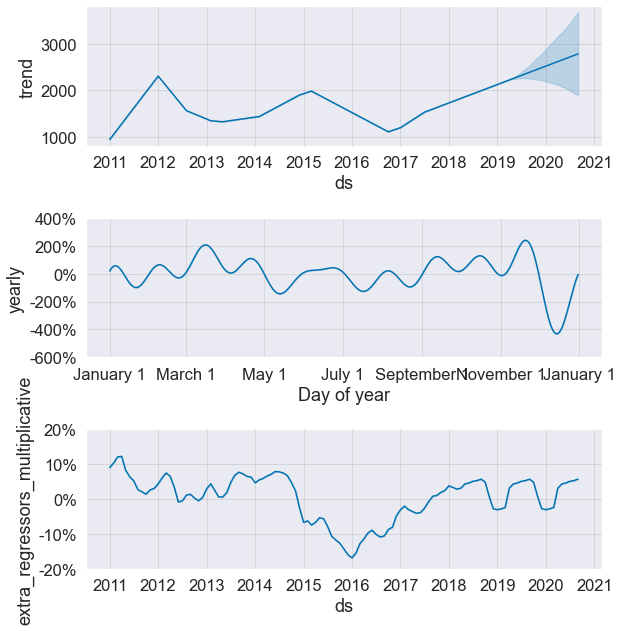

In [46]:
forecast = m.predict(future)
fig = m.plot_components(forecast)

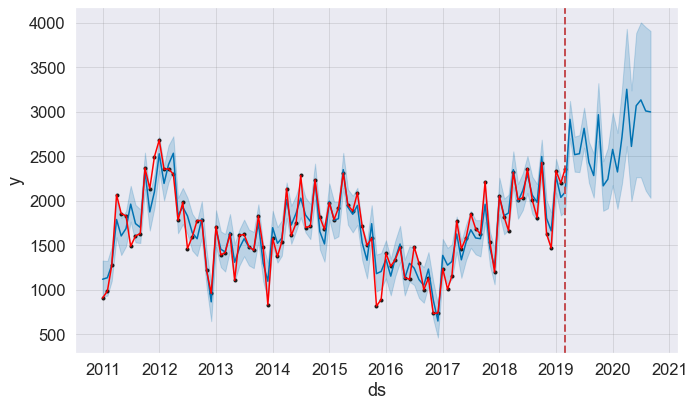

In [47]:
fig = m.plot(forecast, uncertainty=True)
plt.axvline(df['ds'].iloc[df.shape[0]-1], color='r', linestyle='--', lw=2)
plt.plot(df['ds'], df['y'], color="red" )

In [48]:
metric_df = forecast.set_index('ds')[['yhat']].join(df.set_index('ds').y).reset_index()
metric_df.dropna(inplace=True)

In [49]:
print('Forecast Accuracy of: Customer Volumes')
accuracy_prod = forecast_accuracy(metric_df.yhat.values, metric_df.y)
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))


Forecast Accuracy of: Customer Volumes
mape   :  0.0843
me     :  0.3457
mae    :  124.4716
mpe    :  0.0153
rmse   :  158.0249
corr   :  0.9342
minmax :  0.0763


### next 18 month forecast

In [57]:
forecast.tail(18)[['ds','yhat']]

,ds,yhat
99,2019-04-01,2913.847973
100,2019-05-01,2517.407804
101,2019-06-01,2527.993299
102,2019-07-01,2812.965193
103,2019-08-01,2430.233013
104,2019-09-01,2282.417843
105,2019-10-01,2965.761575
106,2019-11-01,2166.959331
107,2019-12-01,2241.803120
108,2020-01-01,2576.320585


### SARIMAX Model 

ACF plot: is a bar chart of the coefficients of correlation between a time series and its lags. It helps determine the value of p or the AR term.

PACF plot: a plot of the partial correlation coefficients between the series and lags of itself. Helps determine the value of q or the MA term


In [60]:
df=df.rename(columns = {'ds':'Month','y':'Customer Volumes'})

df = df.set_index('Month')

In [61]:
df

,y,IDX1,IDX2,IDX3
Month,,,,
2011-01-01,908.0,92.690595,108.008014,101.2842
2011-02-01,986.0,97.914192,102.123691,101.3352
2011-03-01,1276.0,108.645217,101.238374,101.2392
2011-04-01,2066.0,116.243167,109.568848,100.9917
2011-05-01,1856.0,108.068513,110.511852,100.5940
...,...,...,...,...
2018-11-01,1629.0,62.316667,97.431685,100.9204
2018-12-01,1469.0,53.960000,94.062920,100.6184
2019-01-01,2336.0,56.583333,80.055366,100.4775


In [75]:
df_differenced_all = df.diff().dropna()

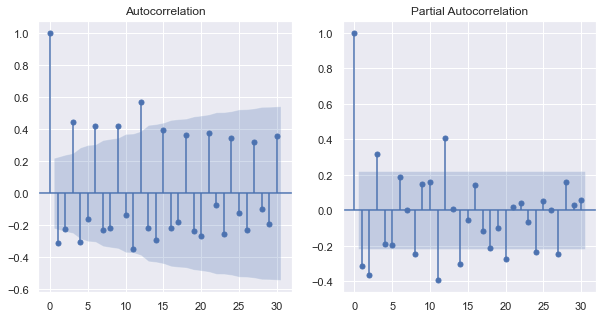

In [45]:
#Correlograms
fig,ax= plt.subplots(1,2, figsize=(10,5))
plot_acf(df_differenced['Customer Volumes'], lags = 30, ax= ax[0])
plot_pacf(df_differenced['Customer Volumes'], lags=30, ax=ax[1])
plt.show()

From results,looks like ARIMA(p=12,d=1,q=?) model

In [76]:
n_obs=18

df_train, df_test = df[0:-n_obs], df[-n_obs:]
print(df_train.shape, df_test.shape)

(81, 4) (18, 4)


In [77]:
train_X, train_y = df_train.loc[:, df_train.columns != 'Customer Volumes'], df_train[['Customer Volumes']]
test_X, test_y = df_test.loc[:, df_test.columns != 'Customer Volumes'], df_test[['Customer Volumes']]

In [78]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model= SARIMAX(train_y, 
 exog=train_X,
 order=(0,1,1),
 enforce_invertibility=False, enforce_stationarity=False)

In [79]:
# fit model
results= model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.94711D+00    |proj g|=  9.87952D-02

At iterate    5    f=  6.94205D+00    |proj g|=  5.41218D-03

At iterate   10    f=  6.93856D+00    |proj g|=  6.66547D-02

At iterate   15    f=  6.93543D+00    |proj g|=  3.97265D-04

At iterate   20    f=  6.93524D+00    |proj g|=  2.97382D-03

At iterate   25    f=  6.93519D+00    |proj g|=  6.04773D-05

At iterate   30    f=  6.93513D+00    |proj g|=  2.01383D-03

At iterate   35    f=  6.93501D+00    |proj g|=  3.51973D-04

At iterate   40    f=  6.93501D+00    |proj g|=  2.41469D-04

At iterate   45    f=  6.93499D+00    |proj g|=  3.54303D-03

At iterate   50    f=  6.93426D+00    |proj g|=  1.72219D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


In [80]:
from pmdarima.arima import auto_arima
step_wise=auto_arima(train_y, 
                     start_p=1,  start_q=1, 
                     max_p=7,  max_q=7, 
                     d=1, max_d=7,
                     trace=True, 
                     error_action='ignore', 
                     suppress_warnings=True, 
                     stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1162.490, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1170.670, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1164.710, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1160.541, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1168.721, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1162.277, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1159.737, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1132.699, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1151.829, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1134.825, Time=0.18 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1159.273, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1151.023, Time=0.12 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1136.292, Time=0.22 sec
 ARIMA(2,1,2)(0,0,0)[0]             : 

In [81]:
step_wise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   81
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -560.369
Date:                Sun, 04 Jul 2021   AIC                           1130.738
Time:                        18:58:43   BIC                           1142.648
Sample:                             0   HQIC                          1135.513
                                 - 81                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9767      0.035    -27.810      0.000      -1.045      -0.908
ar.L2         -0.9916      0.017    -58.730      0.000      -1.025      -0.959
ma.L1          0.8776      0.078     11.216      0.000       0.724       1.031
ma.L2          0.9116      0.112      8.139      0.000       0.692       1.131
sigma2      6.846e+04   1.02e+04      6.732      0.000    4.85e+04    8.84e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.45   Jarque-Bera (JB):                 3.71
Prob(Q):                              0.50   Prob(JB):                         0.16
Heteroskedasticity (H):               0.29   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [82]:
model= SARIMAX(train_y,            
              order=(2,1,2),
              enforce_invertibility=False, enforce_stationarity=False)
results = model.fit()
forecast = results.forecast(steps=2)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.67940D+00    |proj g|=  2.11675D-01

At iterate    5    f=  6.64110D+00    |proj g|=  1.13861D-01

At iterate   10    f=  6.63112D+00    |proj g|=  1.11260D-01

At iterate   15    f=  6.63091D+00    |proj g|=  3.92472D-03

At iterate   20    f=  6.63091D+00    |proj g|=  6.67251D-04

At iterate   25    f=  6.63089D+00    |proj g|=  1.46211D-02

At iterate   30    f=  6.62939D+00    |proj g|=  1.11172D-01

At iterate   35    f=  6.62450D+00    |proj g|=  2.32479D-01

At iterate   40    f=  6.61902D+00    |proj g|=  3.65190D-01

At iterate   45    f=  6.61695D+00    |proj g|=  5.06447D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


In [83]:
train_size = len(df_train)
test_size = len(df_test)

a=train_size+test_size-(steps)-train_size
steps

-1

In [84]:
predictions= results.predict(start =train_size, end=train_size+test_size+(steps)-1,exog=test_X)

In [85]:
forecast_1= results.forecast(steps=test_size-1, exog=test_X)

In [91]:
df_forecast_sarimax = pd.DataFrame(forecast_1)
df_forecast_sarimax

,predicted_mean
2017-10-01,2022.326605
2017-11-01,1725.845836
2017-12-01,1621.731132
2018-01-01,2023.248194
2018-02-01,1731.248812
2018-03-01,1615.462595
2018-04-01,2024.002280
2018-05-01,1736.817015
2018-06-01,1609.199453
2018-07-01,2024.584620


<AxesSubplot:xlabel='Month'>

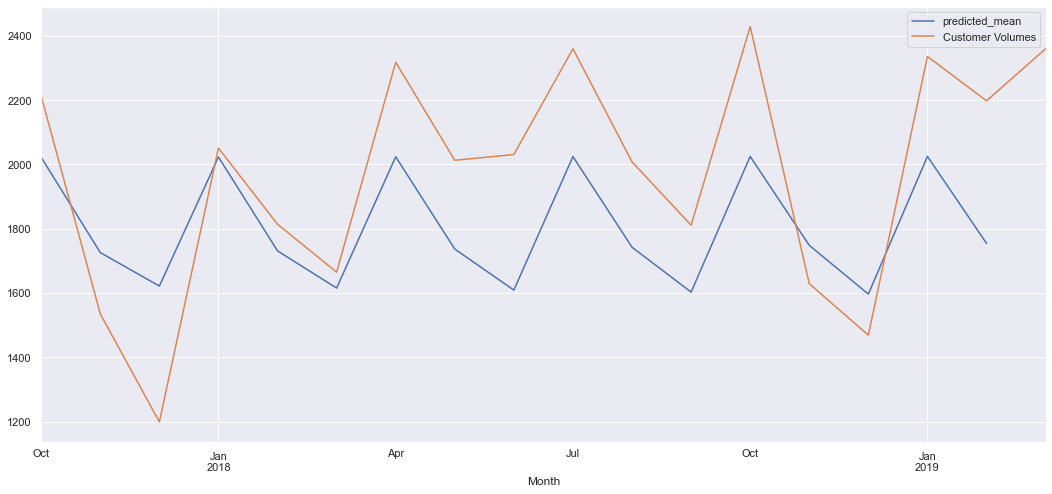

In [93]:
df_forecast_sarimax['predicted_mean'].plot(legend=True)
df_test['Customer Volumes'].plot(legend=True)

In [99]:
np.mean(np.abs(df_forecast_sarimax['predicted_mean'] - df_test['Customer Volumes'])/np.abs(df_test['Customer Volumes']))

0.12789887366872563